In [64]:
import vaex as vx
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from datetime import datetime
from dateutil import parser
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import acf, pacf, arma_order_select_ic
from sklearn.model_selection import ParameterGrid
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from data_struct import dtypes
import warnings

warnings.filterwarnings('ignore')
%matplotlib widget
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
path = os.getcwd()

In [3]:
# Imports data
parse_dates = ['Sale Date', 'Sale Day', 'Sale Date Local']

#custom_dates = lambda x: parser.parse(x) or pd.to_datetime
#You can try both to check speed of import
try:
    data = vx.open('%s//Data//consumption_data.csv.hdf5'%path)
except (FileNotFoundError):
    data = vx.from_csv('%s//Data//consumption_data.csv'%path, 
                       dtype=dtypes, parse_dates=parse_dates, date_parser=pd.to_datetime,
            chunk_size=100_000, convert=True)

In [4]:
# Viewing Data
display(data.head())

#    Service Transaction ID  Sale ID                               Sale Date                        Sale Item ID  Sale Facility Country    Sale Day                       Sale Facility     Sale Facility ID            Mph Arma ID  Customer Type      Vdl Drug ID  Vdl Drug Display Name                 Unit Selling Price Local    Unit Selling Price Usd    Quantity In Units    Quantity In Packs    Sale Item Selling Price Local    Sale Item Selling Price Usd    Unit Vm I Cost Price Local    Sale Item Vm I Cost Price Local    Sale Item Vm I Cost Price Usd    Sale Item Vm I Margin Local    Sale Item Vm I Margin Usd    Unit Cost Price Local    Unit Cost Price Usd    Sale Item Cost Price Local    Sale Item Cost Price Usd    Sale Item Margin Local    Sale Item Margin Usd  Payment Method Type    Payment Timing Type    Product ID                            Product Name                        Product Alias ID                      Product Alias Name                  Patient Facility ID       Patient Facility Name    Patient Risk Tier Type    Corporate Facility Name    Customer Corporate Type    Facility Country    Sale Date Local                Item Category    Item Sub Category    Insurance Pay Or    Product Source      Vat Local (for The It Em)    Vat Usd (for The It Em)  Is Manual    Receipt ID       How Its Sold    Is Off Formula Ry    Mv Drug Abc → Country    Mv Drug Abc → Class    Mv Drug Abc → Class By Value    Mv Drug Abc → Class By Quantity    Mv Drug Abc → Class By Transaction Count    Mv Drug Abc → Class By Margin
  0                     91448  53b21d1b-5f91-4498-81cc-c5c78e5296b8  2020-02-22 20:39:03.550000000           10634  Ghana                    2020-02-22 00:00:00.000000000  3A HEALTH         5e4a8e5ded73cf0076d21dfc        3670829  guest                   165693  LONART DS x1                                             15.93                 2.99195                      1            1                                    15.93                       2.99195                              0                                  0                                0                          15.93                     2.99195                         0                      0                             0                           0                     15.93                2.99195   Cash                   Time of Sale           d3d12db6-c8ac-4bad-9275-0df1bf542501  LONART DS x1                        eeddbfa9-c5c5-4e07-bcc8-73b75a8567b7  LONART DS x1                        5e4a8e5ded73cf0076d21dfc  3A HEALTH                No Policy                 --                         guest                      Ghana               2020-02-22 20:39:03.550000000  DRUGS            Anti-Infectives      None                formulary                                   0                          0  false        1DFC-0000000001  TABLET          false                Ghana                    A                      A                               B                                  A                                           A
  1                     91466  456beab8-433b-43f1-ba0c-0b9a3c62ca45  2020-02-22 13:07:50.726000000           10647  Ghana                    2020-02-22 00:00:00.000000000  Narteva Pharmacy  5e4a8caded73cf0076d21df4        9616396  member                  228432  LOFNAC 100MG TAB 10'S x20                                 1.25                 0.234773                     1            0.05                                  1.25                       0.234773                             0                                  0                                0                           1.25                     0.234773                        0                      0                             0                           0                      1.25                0.234773  Cash                   Time of Sale           09e94d4e-d77e-4b03-8f18-23e7df323d7e  LOFNAC 100MG TAB 10'S x20           e87b0b20-dcd5-4ba7-84df-b55895d96b4f  LOFNAC 100MG TAB 10'S x20

In [5]:
# Place all Column Names in a List
col_names = data.get_column_names()
# Renaming all columns to fit Vaex standards
for i in col_names:
    data.rename(i,i.replace(" ", "_").replace("-","_"))


In [6]:
data.info()

In [7]:
col_names = data.get_column_names()

# Filtering Data to relevant Columns
df = data.copy()[[col_names[2], col_names[4], col_names[5], col_names[6], 
                col_names[9], col_names[10], col_names[11], col_names[12], col_names[13],
                col_names[14], col_names[15],col_names[41], col_names[43], col_names[44], col_names[50]]]

In [8]:
#Dropping Redundant Facilities
df = df[~df['Sale_Facility'].isin(['Emboch Chemist', 'Free Mart Pharmacy'])] 
df

#        Sale_Date                      Sale_Facility_Country    Sale_Day                       Sale_Facility              Customer_Type    Vdl_Drug_ID    Vdl_Drug_Display_Name                          Unit_Selling_Price_Local    Unit_Selling_Price_Usd    Quantity_In_Units    Quantity_In_Packs    Sale_Date_Local                Item_Sub_Category    Insurance_Pay_Or    How_Its_Sold
0        2020-02-22 20:39:03.550000000  Ghana                    2020-02-22 00:00:00.000000000  3A HEALTH                  guest            165693         LONART DS x1                                   15.93                       2.9919522                 1.0                  1.0                  2020-02-22 20:39:03.550000000  Anti-Infectives      None                TABLET
1        2020-02-22 13:07:50.726000000  Ghana                    2020-02-22 00:00:00.000000000  Narteva Pharmacy           member           228432         LOFNAC 100MG TAB 10'S x20                      1.25                        0.2347734                 1.0                  0.05                 2020-02-22 13:07:50.726000000  Analgesics           None                TABLET
2        2020-02-22 21:48:41.710000000  Ghana                    2020-02-22 00:00:00.000000000  3A HEALTH                  guest            165649         FERROUS SULPHATE x28 UK                        0.39                        0.0732493                 2.0                  0.071428575          2020-02-22 21:48:41.710000000  Supplements          None                TABLET
3        2020-02-22 22:05:22.955000000  Ghana                    2020-02-22 00:00:00.000000000  3A HEALTH                  guest            169837         CITRO-C 100MG x25                              1.66                        0.31177908                2.0                  0.08                 2020-02-22 22:05:22.955000000  Supplements          None                TABLET
4        2020-02-22 15:14:34.437000000  Ghana                    2020-02-22 00:00:00.000000000  Narteva Pharmacy           member           234450         MULTIVITAMIN TABS BLISTER 10'S x50             0.22                        0.04132012                30.0                 0.6                  2020-02-22 15:14:34.437000000  Supplements          None                TABLET
...      ...                            ...                      ...                            ...                        ...              ...            ...                                            ...                         ...                       ...                  ...                  ...                            ...                  ...                 ...
588,881  2020-01-07 14:09:58.071529000  Ghana                    2020-01-07 00:00:00.000000000  Fresh Spring Chemists Ltd  guest            240472         ENACIN-C 300MG CAPS x100                       1.03                        0.18739937                20.0                 0.2                  2020-01-07 14:09:58.071529000  Anti-Infectives      None                --
588,882  2019-11-17 13:40:09.826139000  Ghana                    2019-11-17 00:00:00.000000000  CENTRIXMAS PHARMACY        guest            228432         LOFNAC 100MG TAB 10'S x20                      1.35                        0.25092936                1.0                  0.05                 2019-11-17 13:40:09.826139000  Analgesics           None                --
588,883  2019-11-09 13:41:26.221462000  Ghana                    2019-11-09 00:00:00.000000000  Daelyn Pharmacy            guest            228432         LOFNAC 100MG TAB 10'S x20                      1.35                        0.25092936                1.0                  0.05                 2019-11-09 13:41:26.221462000  Analgesics           None                --
588,884  2019-12-23 20:04:53.364947000  Ghana                    2019-12-23 00:00:00.000000000  Immaculate Pharmacy Ltd    member           229889         ALLERGY RELIEF TABS (CETIRIZINE 10MG) 10'S x1  16.17                       3.0055761

In [9]:
# Viewing the Relevant Columns
df.get_column_names()
# Sort Time Series
# df = df.sort(by='Sale_Date', ascending=True)

['Sale_Date',
 'Sale_Facility_Country',
 'Sale_Day',
 'Sale_Facility',
 'Customer_Type',
 'Vdl_Drug_ID',
 'Vdl_Drug_Display_Name',
 'Unit_Selling_Price_Local',
 'Unit_Selling_Price_Usd',
 'Quantity_In_Units',
 'Quantity_In_Packs',
 'Sale_Date_Local',
 'Item_Sub_Category',
 'Insurance_Pay_Or',
 'How_Its_Sold']

**ANALYSES PER FACILITY**

In [10]:
#For mock purposes we will go with the facility with the highest number of rows

count = 0
for facility in df['Sale_Facility'].unique():
    if len(df[df['Sale_Facility']==facility]) > count:
        count = len(df[df['Sale_Facility']==facility])
        largest = facility

print(f"{largest} is the largest facility in terms of volume of transactions with  {count} transactions")


Fresh Spring Chemists Ltd is the largest facility in terms of volume of transactions with  53037 transactions


In [11]:
#Using the same idea to get the Item with the highest volume of transactions on
fty_df = df[df['Sale_Facility'] == largest]

count = 0
for item_class in df['Item_Sub_Category'].unique():
    if len(df[df['Item_Sub_Category'] == item_class]) > count:
        count = len(df[df['Item_Sub_Category'] == item_class])
        largest = item_class

print(f"{largest} are sold more often with {count} volume of transactions")


Analgesics are sold more often with 124658 volume of transactions


In [12]:
#Since no data represents medications with no class intuitive conclusions cant be draw with regards to class.
#Lets go with Anti-Infectives instead

con_df = fty_df[fty_df['Item_Sub_Category'] == largest]

In [13]:
#Split the data into the respective Date Frequencies eg. Yearly, Monthly, Weekly, Daily, Hourly
#We are using quantity in Units because you can derive the pack size from it

freq_dict = {}
for i in zip(['W', 'M'], ['weekly', 'monthly']):
    freq_dict[i[1]] = con_df.groupby(by=vx.BinnerTime(con_df['Sale_Date'], resolution=i[0]), agg={'Quantity_In_Units':'sum'})


**PREPROCESSING AND VISUALIZATION**

In [14]:
#Develop in house function for rolling means/std since vaex has no inbuilt function for this

def rolling_window(a, window, find_mean, find_std):
    old_shape = a.shape[0]
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    view = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    
    if find_mean:
        final = np.array([view[i,:].mean() for i in range(view.shape[0])])
        
    elif find_std:
        final = np.array([view[i,:].std() for i in range(view.shape[0])])
        
    new_shape = view.shape[0]
    zeros = np.array([0 for x in range(old_shape - new_shape)])
    result = np.concatenate((zeros,final))
    return result

In [15]:
#Build function for plots to showcase the rolling window and SavGol

def plots(x, y, title, window=3, ylabel='Quantity Sold in Units', mean=False, std=False, sav=False):
    date="%b, %d %Y"
    xlabel='Date'
    
    fig = plt.figure()
    plt.plot_date(x, y, linestyle='solid', marker=None, fmt='g', label='Main Time Series Data')
    if sav:
        plt.plot_date(x, savgol_filter(y,window,3),
                      linestyle='solid', marker=None, fmt='y', label='Saviztky Golay Algo with Window Size of %s'%window)
    if mean:
        plt.plot_date(x, rolling_window(y,window=window,find_mean=True,find_std=False),
                      linestyle='solid', marker=None, fmt='r', label='Moving Average with Window Size of %s'%window)
    if std:
        plt.plot_date(x, rolling_window(y,window=window,find_std=True, find_mean=False),
                      linestyle='solid', marker=None, fmt='b', label='Moving Std with Window Size of %s'%window)
    plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter(date)
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.title(title)
    plt.tight_layout()
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
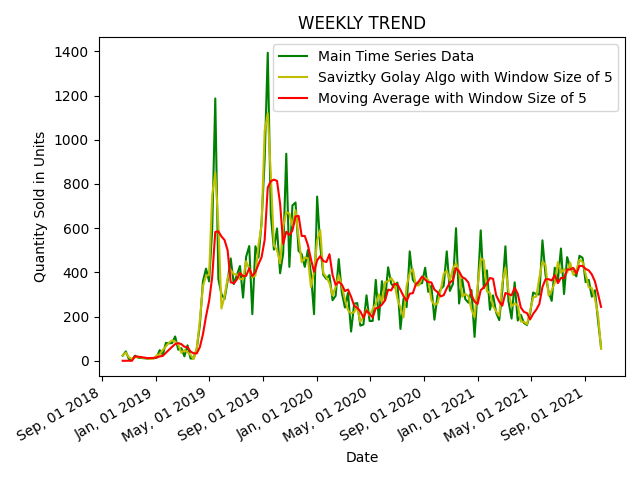

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
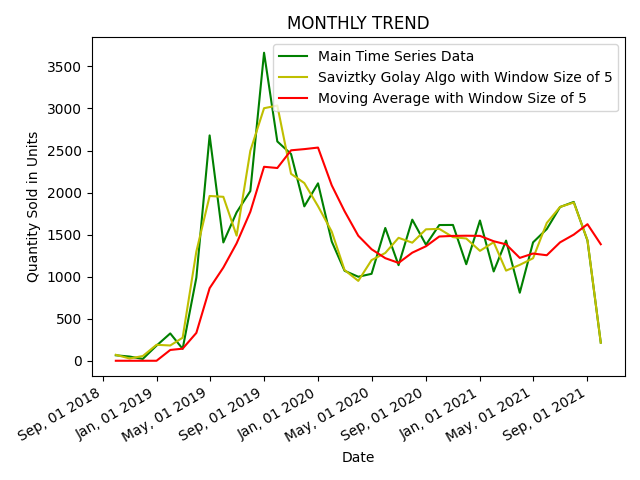

In [50]:
windows = [16, 12]

for freq in freq_dict.keys():
    plots(freq_dict[freq]['Sale_Date'].values, freq_dict[freq]['Quantity_In_Units'].values,
          f'{freq} Trend'.upper(),5, mean=True, sav=True)

### **Stationarity Check With ADF Test**

In [17]:
# Adfuller Test to Check for Stationary Datasets
def stat_check(data, ts):
    test = adfuller(data, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic', 'P-value', '#lags used', 'Number of Observations Used'])
    for key,value in test[4].items():
        results['Critical Value (%s)'%key] = value
    
    print(f'Results of Dickey Fuller Test for {ts} Data \n{results}')


for freq in freq_dict.keys():
    stat_check(freq_dict[freq]['Quantity_In_Units'].values, freq.upper())



Results of Dickey Fuller Test for WEEKLY Data 
Test Statistic                  -3.349615
P-value                          0.012801
#lags used                       2.000000
Number of Observations Used    150.000000
Critical Value (1%)             -3.474715
Critical Value (5%)             -2.881009
Critical Value (10%)            -2.577151
dtype: float64
Results of Dickey Fuller Test for MONTHLY Data 
Test Statistic                 -1.791154
P-value                         0.384862
#lags used                      7.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


### **1. Seasonal Decomposition to Ensure Stationarity**

In [18]:
# One means of ensuring stationarity is decomposing and taking the residuals
def decompose(data, t_series, period, show_plot=True):
    result = seasonal_decompose(data, period=12)
    if show_plot:
        plots(t_series, result.trend, 'Trend')
        plots(t_series, result.seasonal, 'Seasonality')
        plots(t_series, result.resid, 'Residuals')
    return np.nan_to_num(result.resid, 0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
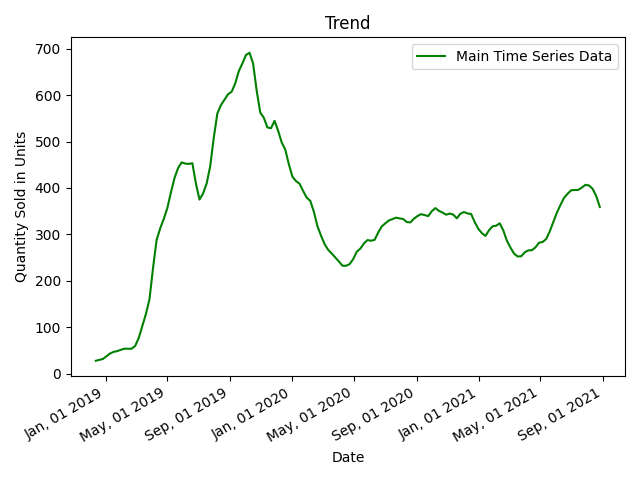

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
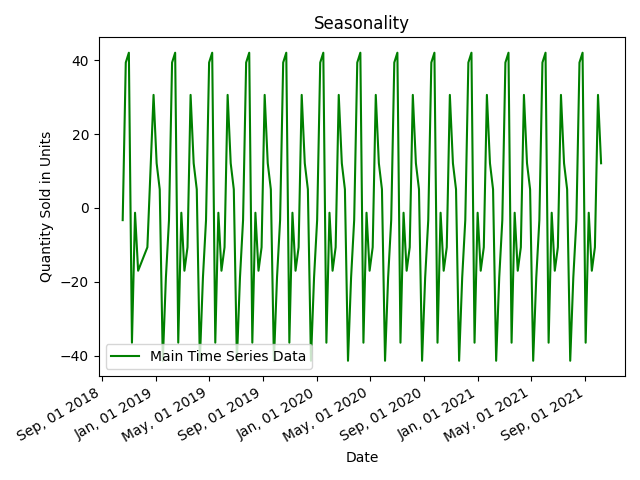

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
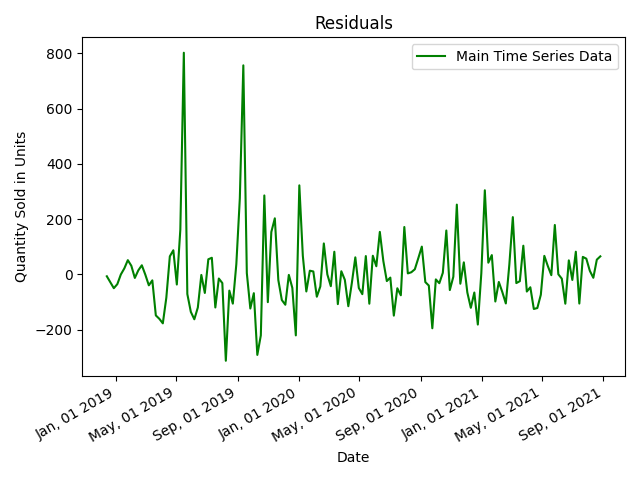

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
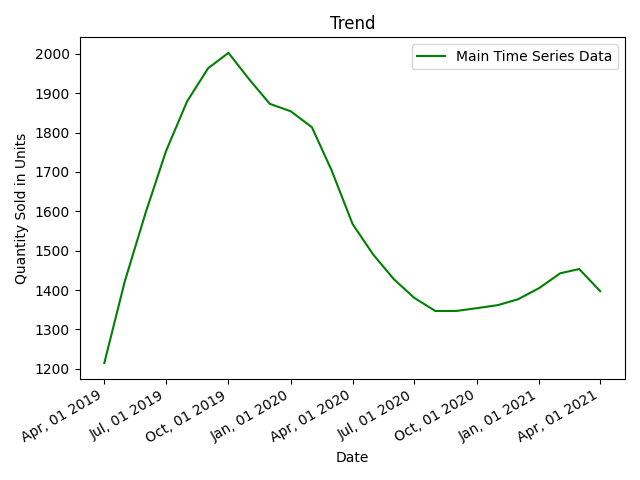

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
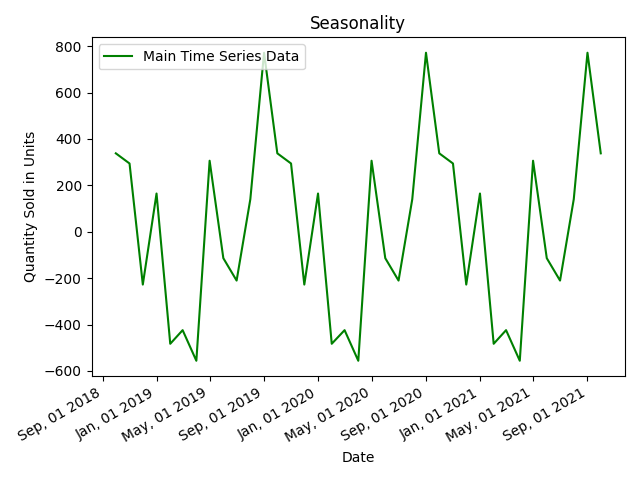

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
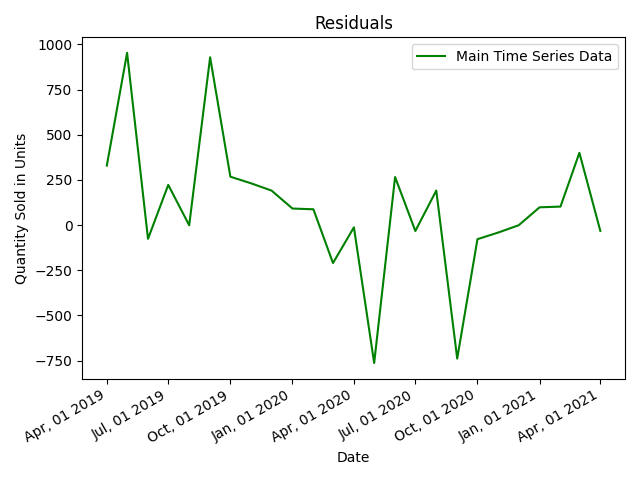

In [19]:
for freq in freq_dict.keys():
    residuals = decompose(freq_dict[freq]['Quantity_In_Units'].values,
                              freq_dict[freq]['Sale_Date'].values, period=12)
    freq_dict[freq]['residuals'] = residuals


### **2. Log of the Values**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
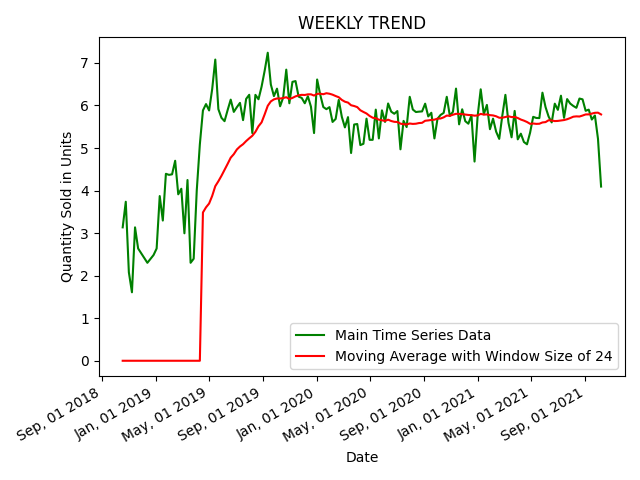

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
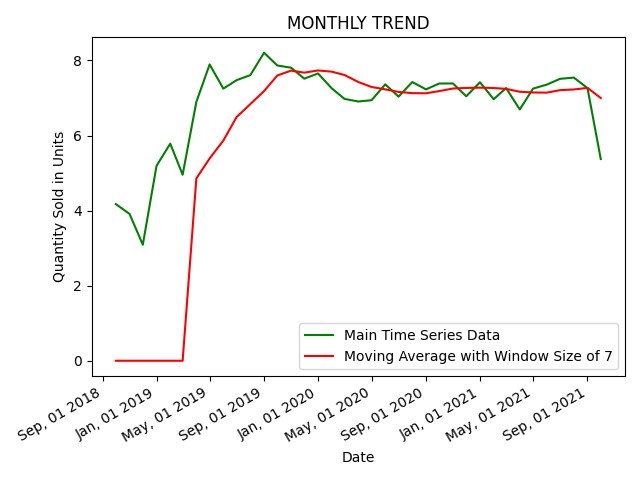

In [20]:
for freq in freq_dict.keys():
    freq_dict[freq]['log'] = freq_dict[freq]['Quantity_In_Units'].apply(lambda x: np.log(x))

for freq in zip(freq_dict.keys(), [24, 7, 4, 12]):
    plots(freq_dict[freq[0]]['Sale_Date'].values, freq_dict[freq[0]]['log'].values,
          f'{freq[0]} Trend'.upper(), freq[1], mean=True, sav=False)

In [21]:
for freq in freq_dict.keys():
    stat_check(freq_dict[freq]['log'].values, freq.upper())

Results of Dickey Fuller Test for WEEKLY Data 
Test Statistic                  -3.938661
P-value                          0.001768
#lags used                       8.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64
Results of Dickey Fuller Test for MONTHLY Data 
Test Statistic                 -2.468085
P-value                         0.123434
#lags used                      0.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


### 3. **Subtracting Rolling Mean**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
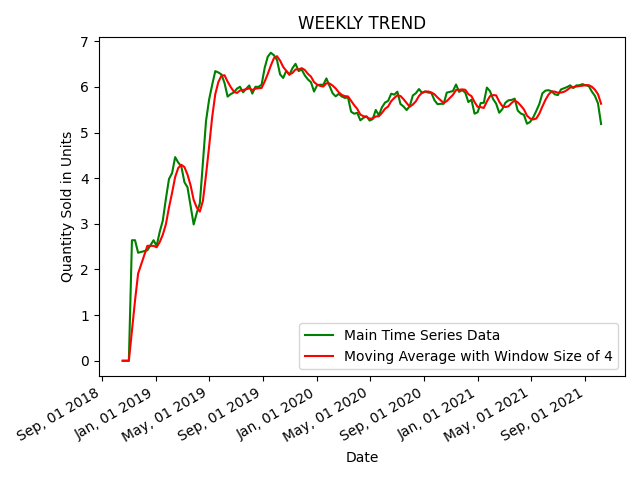

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
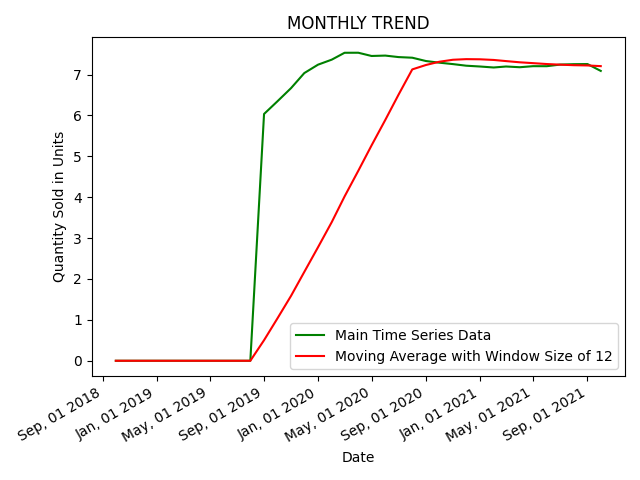

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
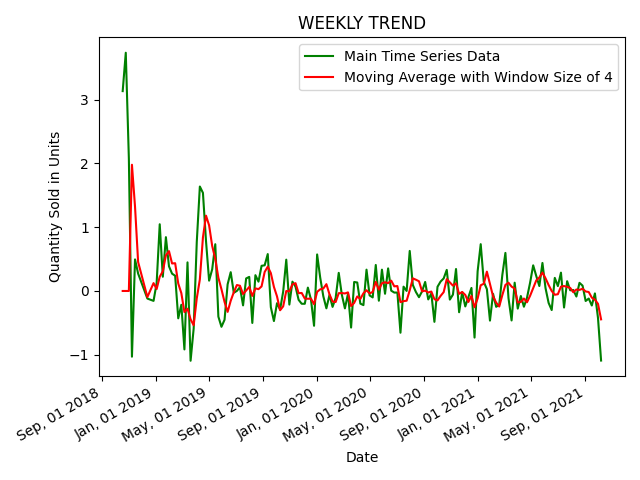

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
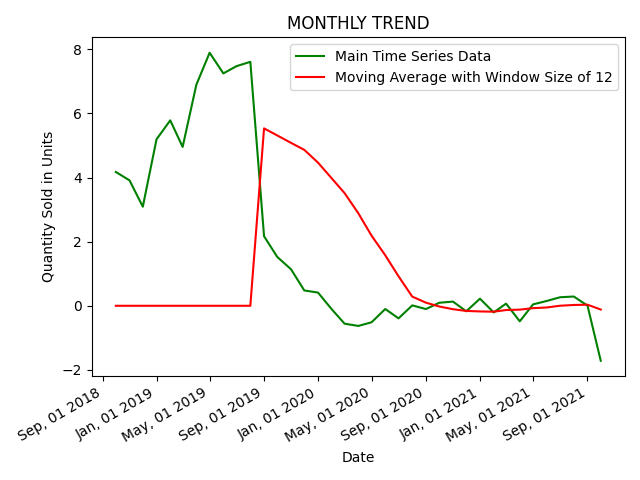

In [22]:
for freq in zip(freq_dict.keys(), windows):
    freq_dict[freq[0]]['roll_mean'] = rolling_window(freq_dict[freq[0]]['log'].values, freq[1], find_mean=True, find_std=False)
    freq_dict[freq[0]]['diff_rolling'] = freq_dict[freq[0]]['log'] - freq_dict[freq[0]]['roll_mean']

for col in ['roll_mean', 'diff_rolling']:
    for freq in zip(freq_dict.keys(), windows):
        plots(freq_dict[freq[0]]['Sale_Date'].values, freq_dict[freq[0]][col].values,
              f'{freq[0]} Trend'.upper(), freq[1], mean=True, sav=False)

In [23]:
for freq in freq_dict.keys():
    stat_check(freq_dict[freq]['diff_rolling'].values, freq.upper())

Results of Dickey Fuller Test for WEEKLY Data 
Test Statistic                -6.398108e+00
P-value                        2.027013e-08
#lags used                     5.000000e+00
Number of Observations Used    1.470000e+02
Critical Value (1%)           -3.475637e+00
Critical Value (5%)           -2.881410e+00
Critical Value (10%)          -2.577365e+00
dtype: float64
Results of Dickey Fuller Test for MONTHLY Data 
Test Statistic                 -1.032874
P-value                         0.741086
#lags used                      1.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


### **4. Subtracting Exponential Rolling Means**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
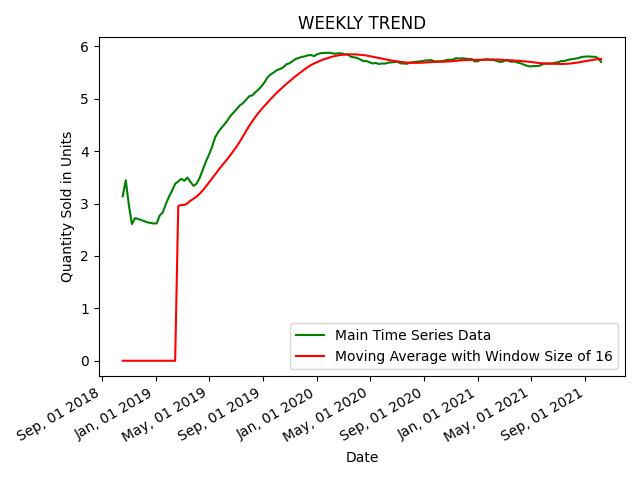

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
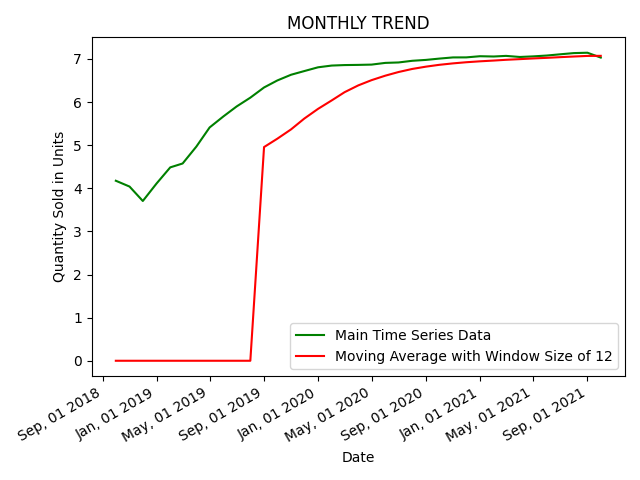

In [51]:
for freq in zip(freq_dict.keys(), windows):
    temp_df = pd.Series(freq_dict[freq[0]]['log'].values)
    freq_dict[freq[0]]['diff_ewm'] = temp_df.ewm(halflife = freq[1], min_periods=0, adjust=True).mean().values


for freq in zip(freq_dict.keys(), windows):
    plots(freq_dict[freq[0]]['Sale_Date'].values, freq_dict[freq[0]]['diff_ewm'].values,
          f'{freq[0]} Trend'.upper(), freq[1], mean=True, sav=False)

In [25]:
for freq in freq_dict.keys():
    stat_check(freq_dict[freq]['diff_ewm'].values, freq.upper())

Results of Dickey Fuller Test for WEEKLY Data 
Test Statistic                  -3.426144
P-value                          0.010099
#lags used                       9.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64
Results of Dickey Fuller Test for MONTHLY Data 
Test Statistic                 -2.670861
P-value                         0.079218
#lags used                      0.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


### **5. Differencing of the Dataset**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
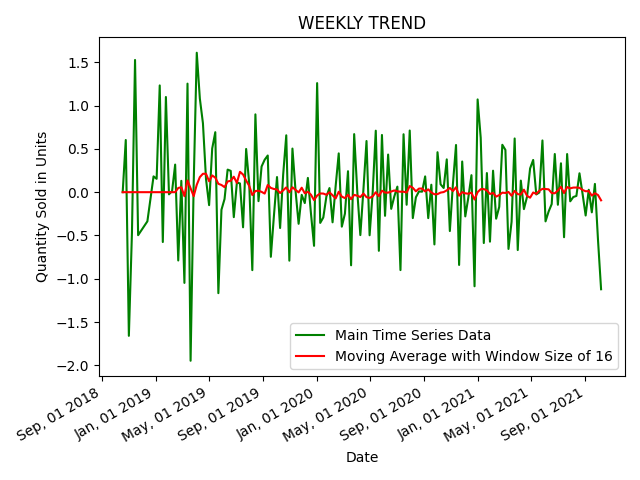

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
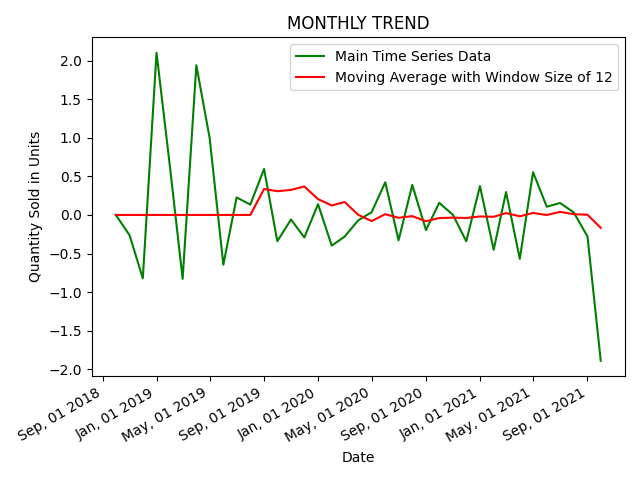

In [54]:
for freq in freq_dict.keys():
    temp_df = pd.Series(freq_dict[freq]['log'].values)
    freq_dict[freq]['diff_shift'] = np.nan_to_num(np.array(temp_df - temp_df.shift()), 0)

for freq in zip(freq_dict.keys(), windows):
    plots(freq_dict[freq[0]]['Sale_Date'].values, freq_dict[freq[0]]['diff_shift'].values,
          f'{freq[0]} Trend'.upper(), freq[1], mean=True, sav=False)

In [27]:
for freq in freq_dict.keys():
    stat_check(freq_dict[freq]['diff_ewm'].values, freq.upper())

Results of Dickey Fuller Test for WEEKLY Data 
Test Statistic                  -3.426144
P-value                          0.010099
#lags used                       9.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64
Results of Dickey Fuller Test for MONTHLY Data 
Test Statistic                 -2.670861
P-value                         0.079218
#lags used                      0.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


### **MODELLING WITH ARIMA AND SARIMAX**

In [28]:
# # Differencing
# def diff(dataset, interval, col):
#     result = []
#     for i in range(interval, len(dataset)):
#         offset = i - interval
#         value = dataset[col].values[i] - dataset[col].values[offset]
#         result.append(value)
#     return (result)

# %lprun -f diff diff(dataset=anti_d, interval=1, col="log_data")

In [44]:
# You can determine the p and q lags using the plots however, i choose to use this automated approach and iterate
# through the possible combinations of lags i can get
bic_order = {}
for freq in freq_dict.keys():
    bic = arma_order_select_ic(freq_dict[freq].diff_shift.values)
    bic_order[freq] = bic['bic_min_order']

print(bic_order)

{'weekly': (0, 1), 'monthly': (0, 0)}


In [30]:
# You can plot pacf and the acf curves as well
def plot_acf_pacf(df, ts):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()  
  return

In [45]:
# function to run our model
def run_arima_model(df, dates, p, d, q, freq):
    """
    Run ARIMA model
    """
    #assign the date to the index of the dataset
    df = pd.Series(df, index=dates)
    
    # fit ARIMA model on time series
    model = ARIMA(df, order=(p, d, q))  
    results_ = model.fit()  

    # get lengths correct to calculate RSS
    len_results = len(results_.fittedvalues)
    ts_modified = df[-len_results:]

    # calculate root mean square error (RMSE) and residual sum of squares (RSS)
    rss = sum((results_.fittedvalues - ts_modified)**2)
    rmse = np.sqrt(rss / len(df))

    # plot fit
    fig = plt.figure()
    plt.plot(dates, df)
    plt.plot(dates, results_.fittedvalues, color = 'red')
    plt.title('ARIMA model (%i, %i, %i) for RSS: %.4f, RMSE: %.4f %s' %(p, d, q, rss, rmse, freq))

    plt.show()  
    return results_ , rmse

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
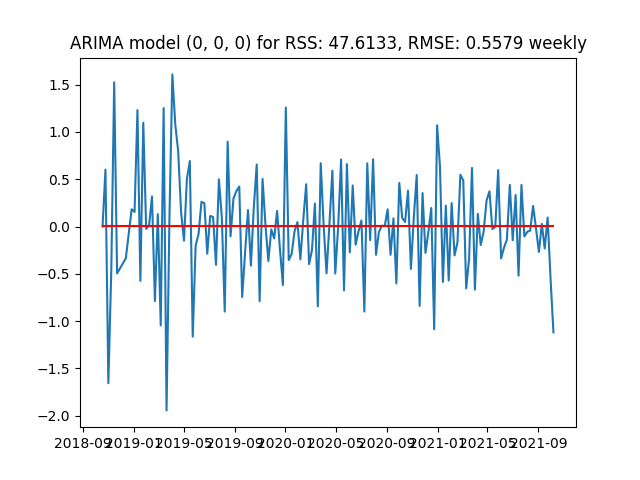

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
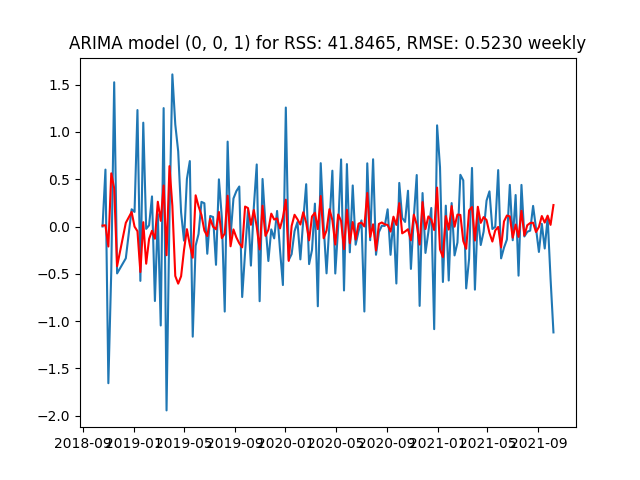

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
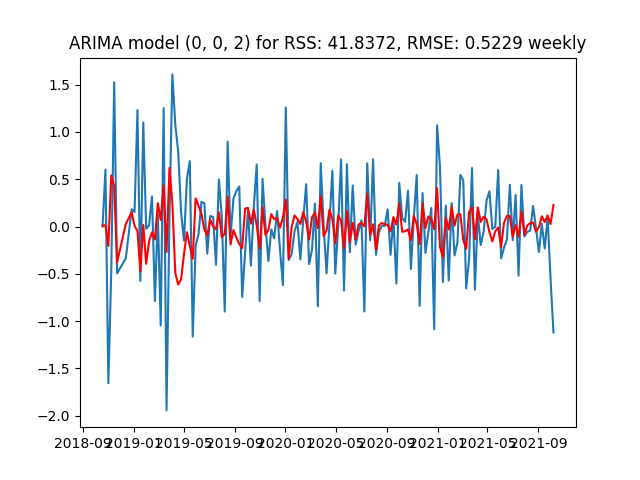

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
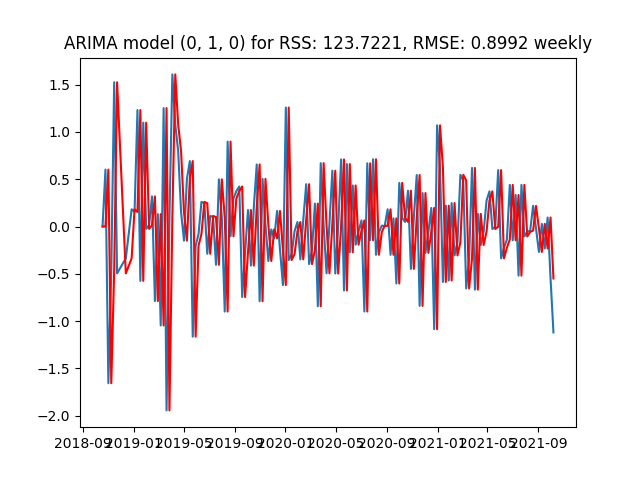

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
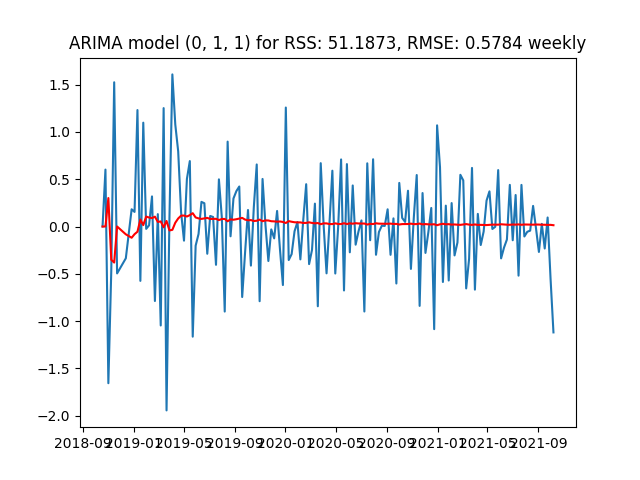

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
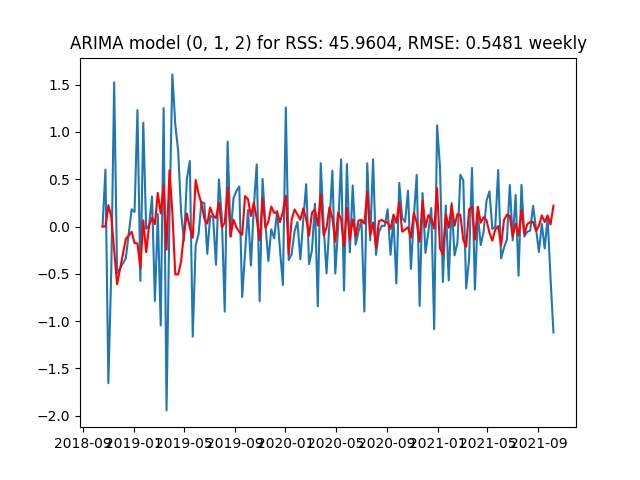

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
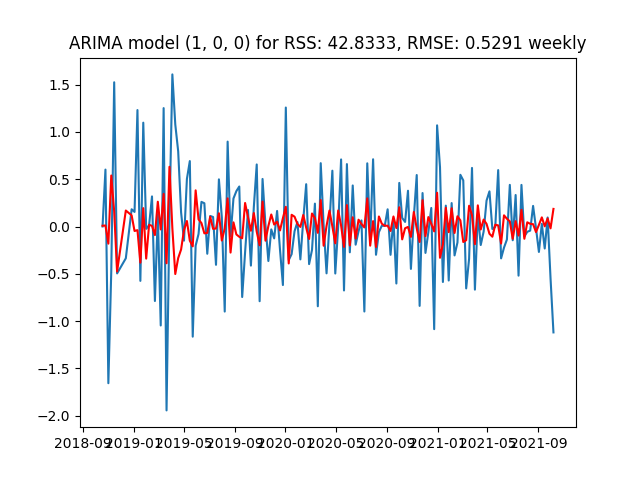

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
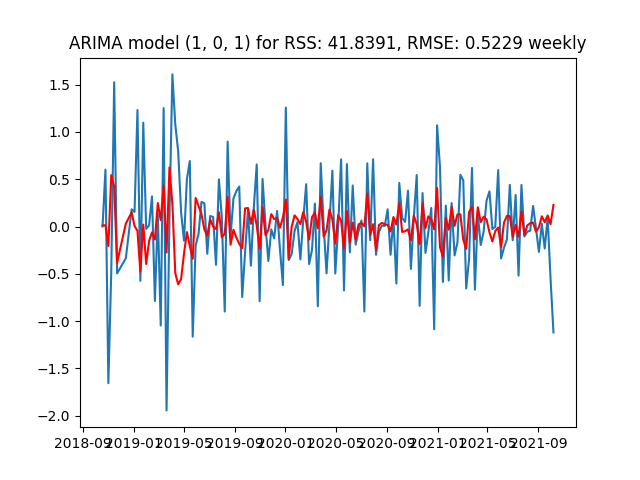

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
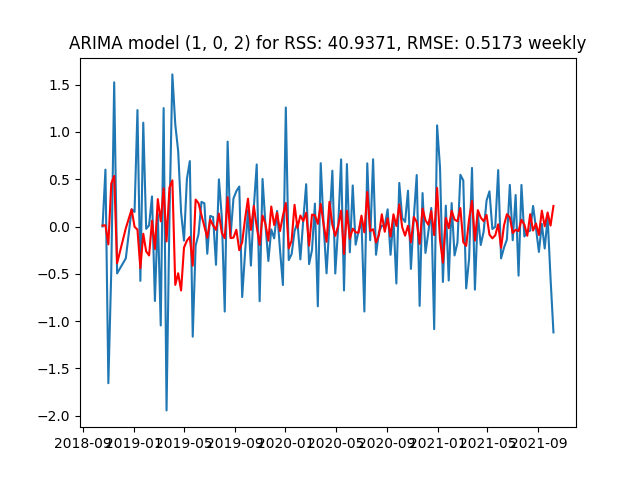

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
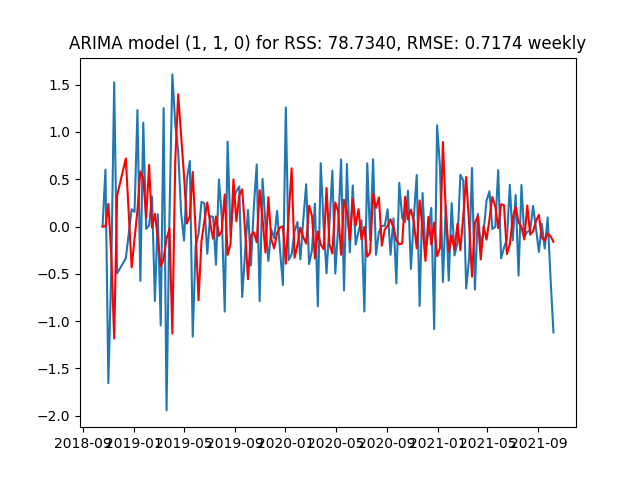

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
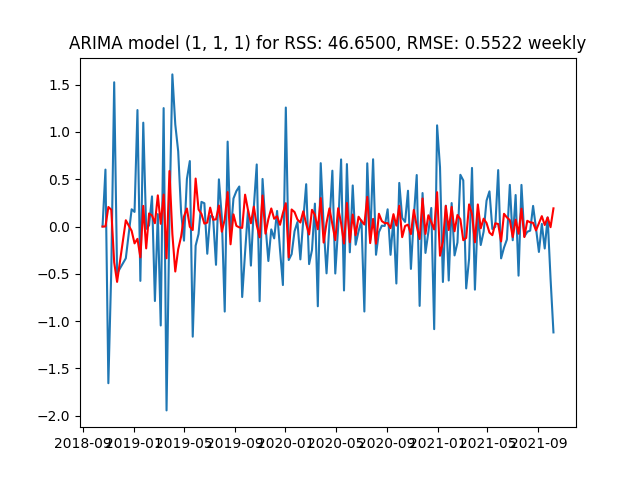

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
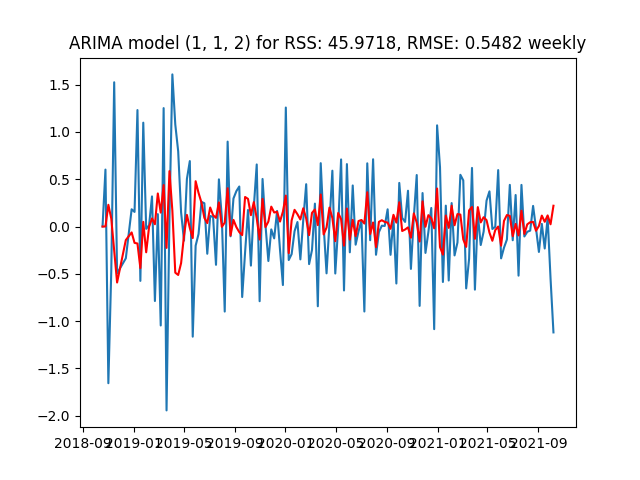

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
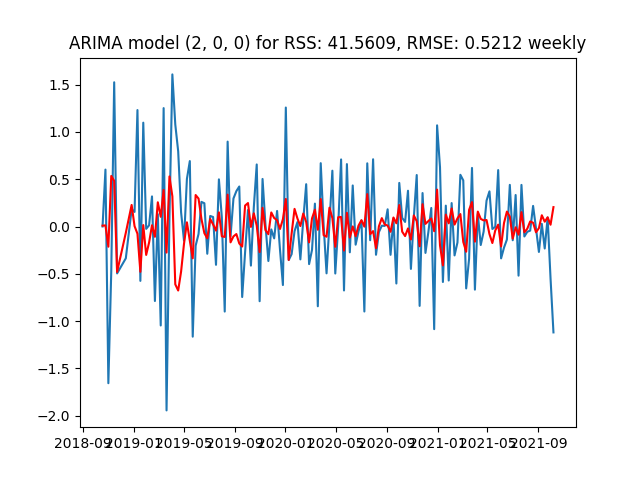

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
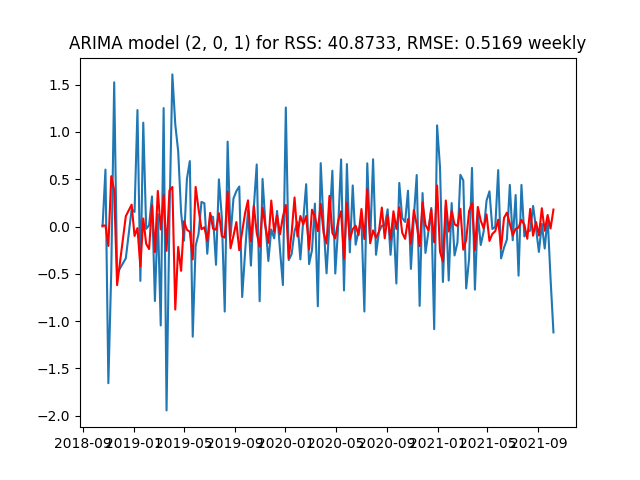

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
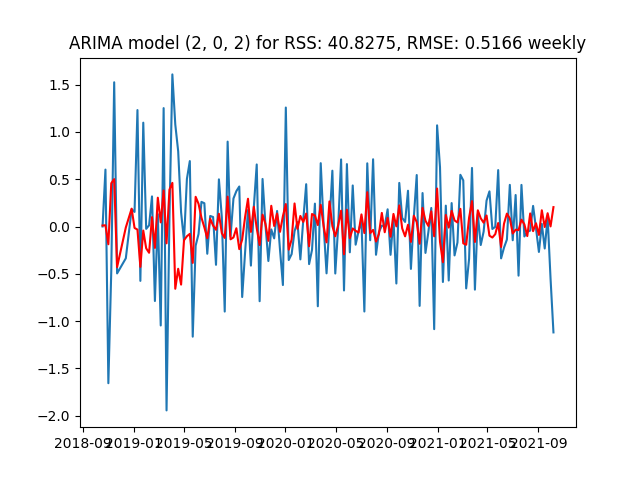

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
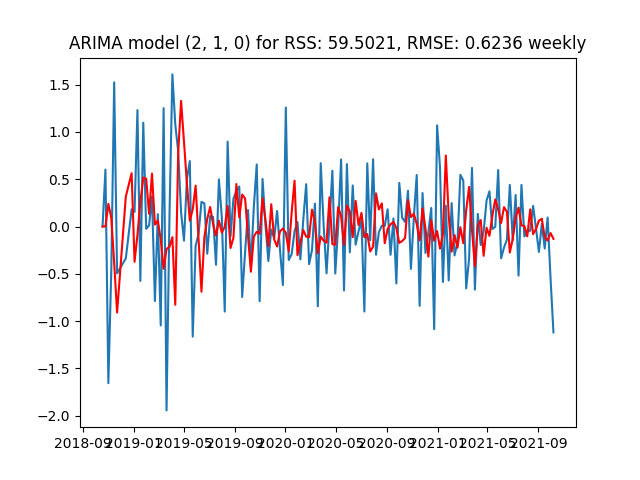

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
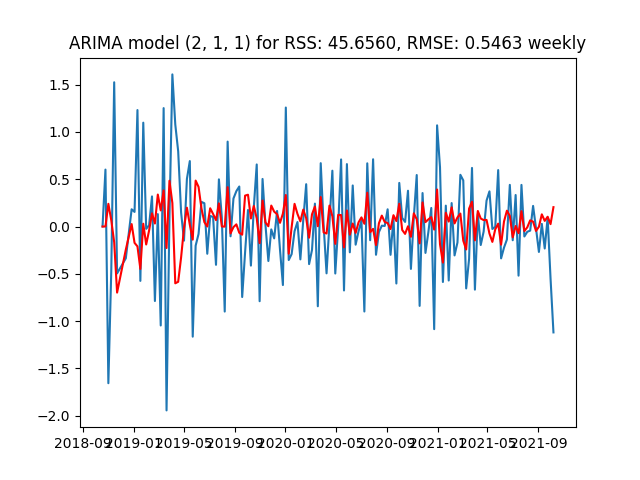

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
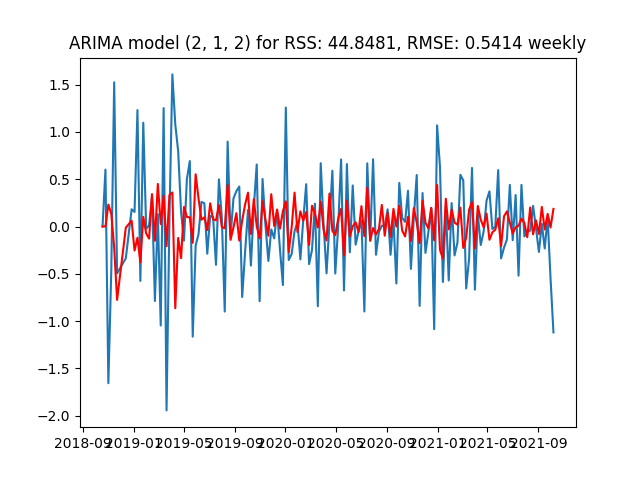

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
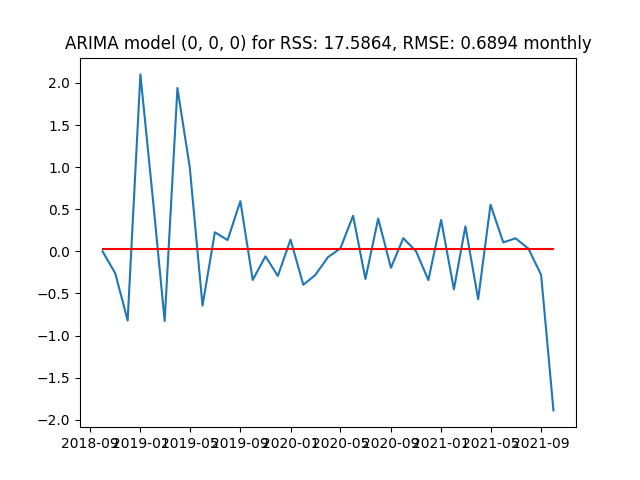

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
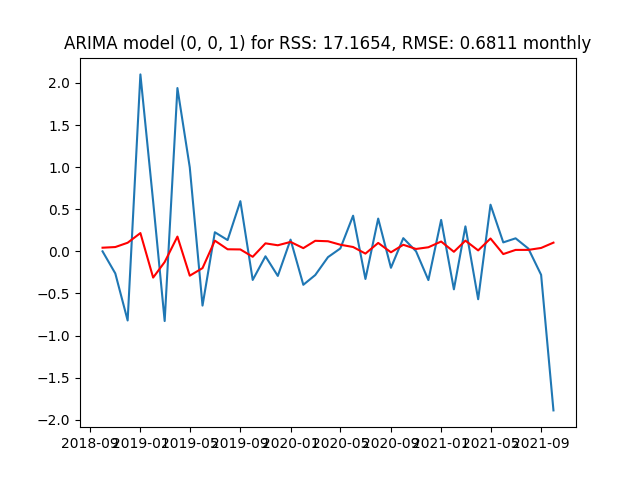

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
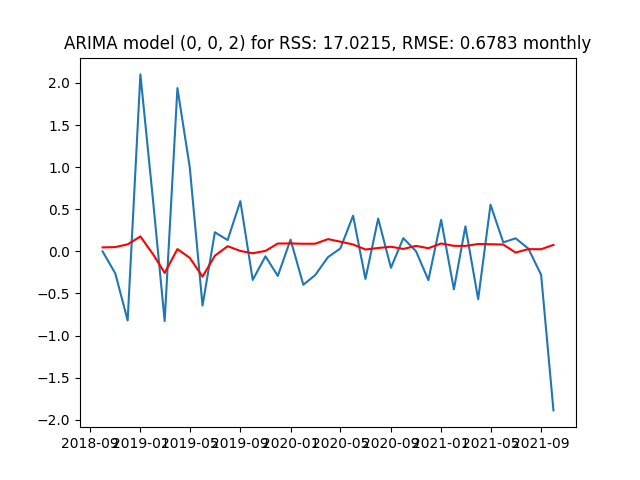

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
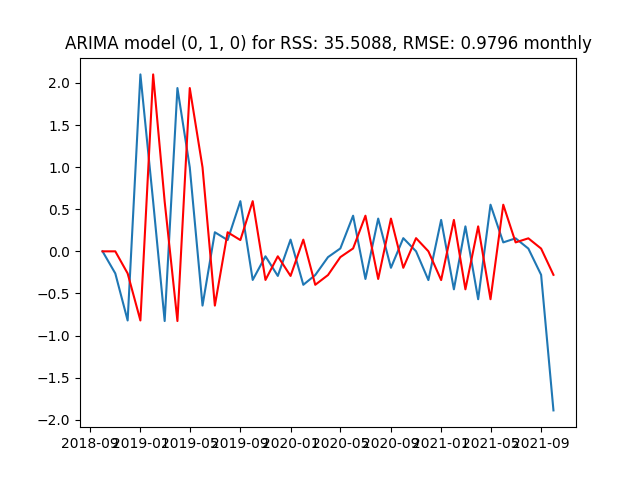

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
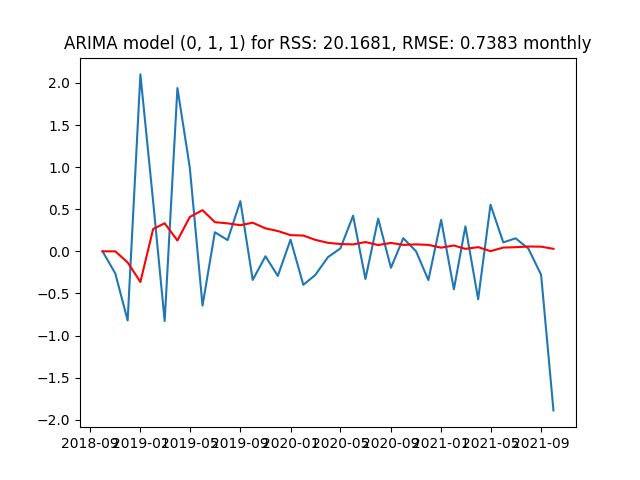

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
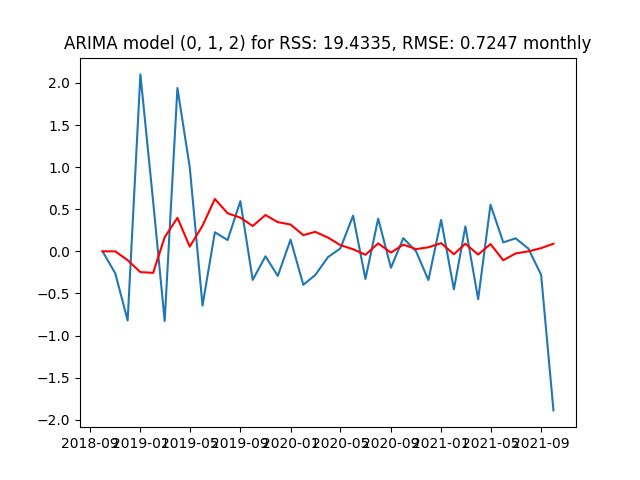

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
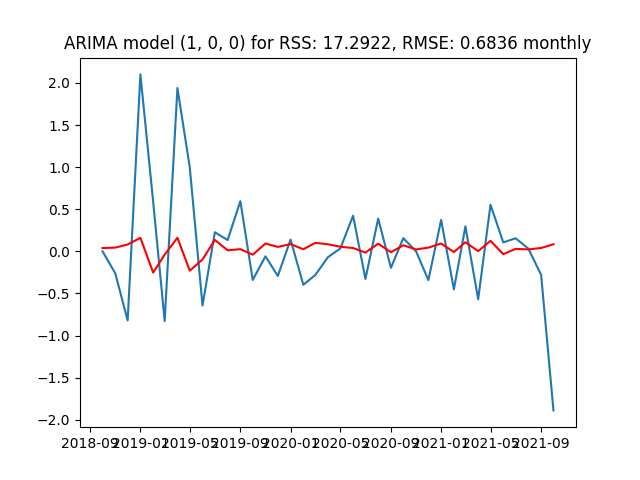

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
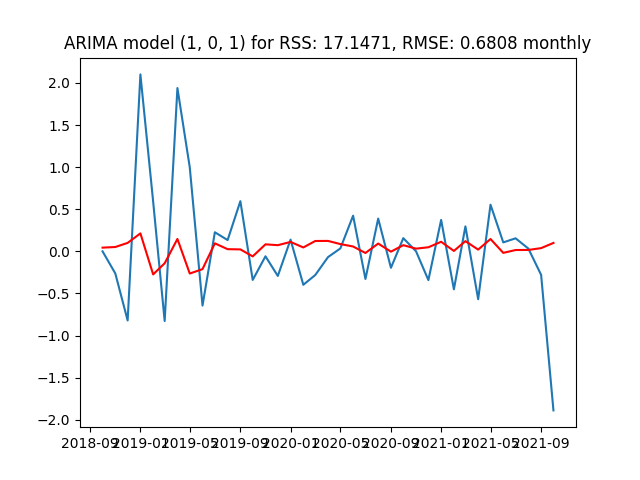

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
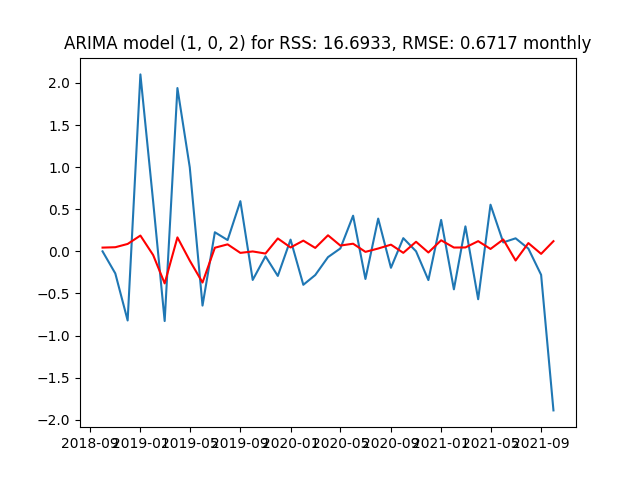

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
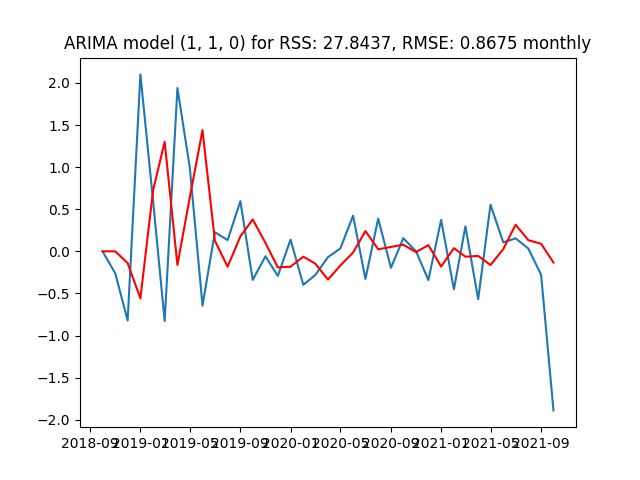

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
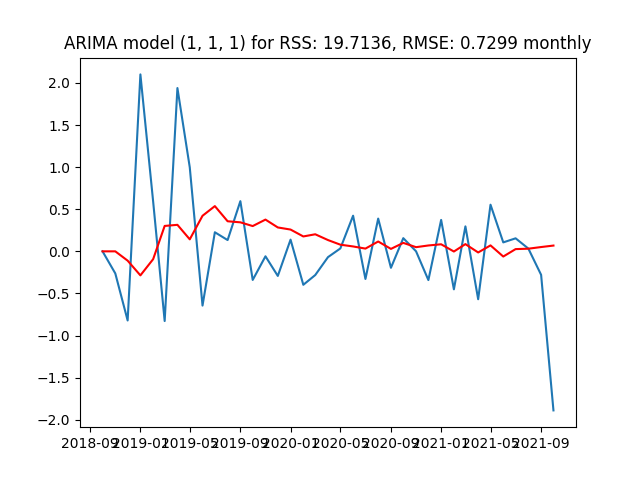

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
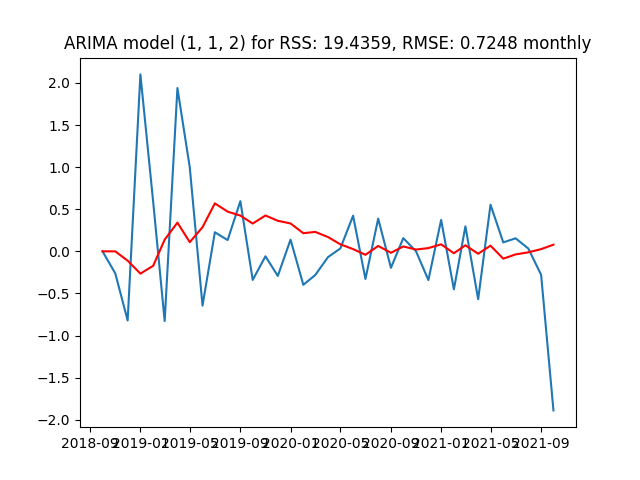

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
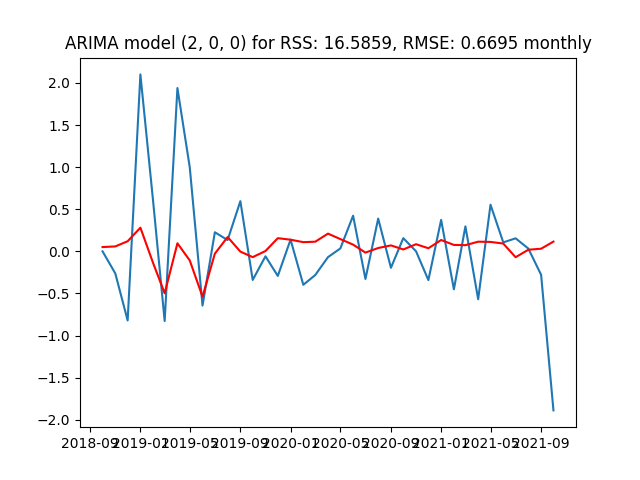

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
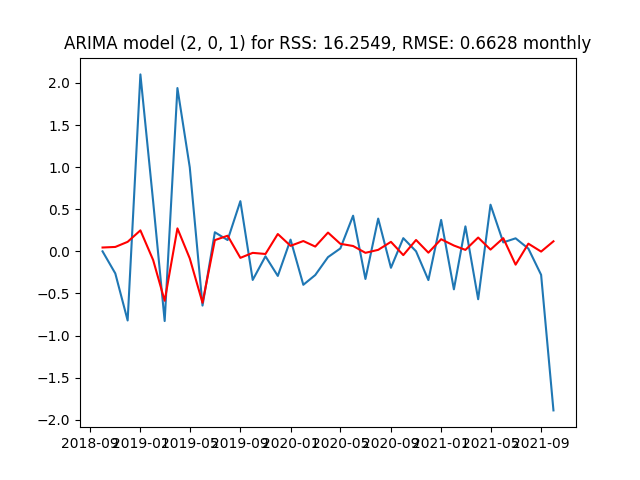

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
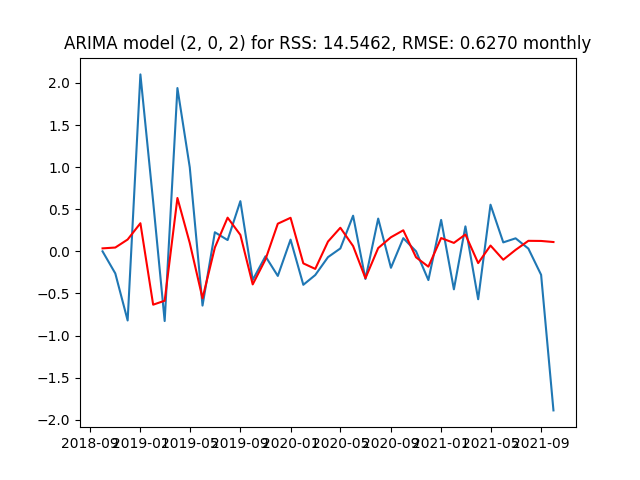

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
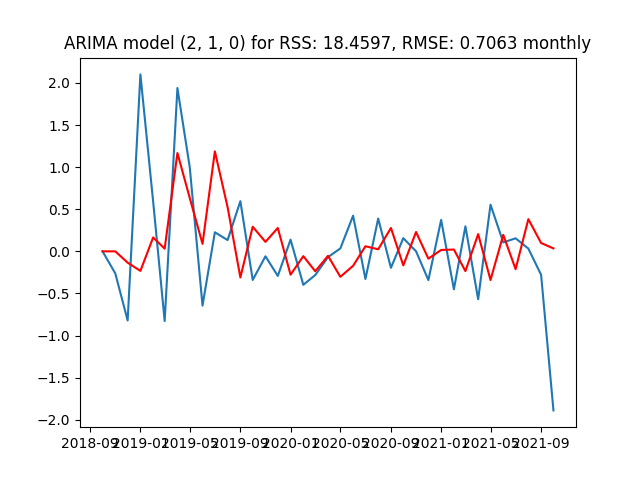

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
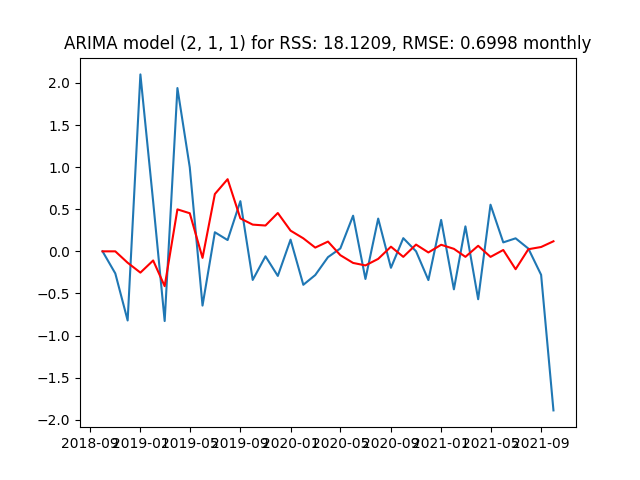

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
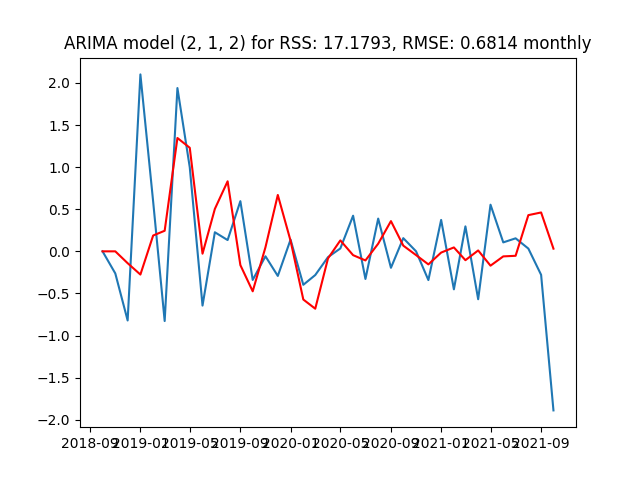

In [48]:
arima_dict = {}
model_list = []

for freq in freq_dict.keys():
    for p in [0,1,2]:
        for d in [0,1]:
            for q in [0,1,2]:
                model_AR = run_arima_model(df=freq_dict[freq].diff_shift.values, dates = freq_dict[freq].Sale_Date.values,
                                           p=p, d=d, q=q, freq=freq)
                if model_list == []:
                    model_list.append(model_AR)
                else:
                    if model_list[0][1] > model_AR[1]:
                        model_list[0] = model_AR
    arima_dict[freq] = model_list[0]
    model_list = []
            

In [65]:
# function to run our model
def run_sarimax_model(df, dates, p, d, q, s, freq):
    """
    Run SARIMAX model
    """
    #assign the date to the index of the dataset
    df = pd.Series(df, index=dates)
    
    # fit SARIMAX model on time series
    model = SARIMAX(df, order=(p, d, q), seasonal_order = (p,d,q,s))  
    results_ = model.fit()  

    # get lengths correct to calculate RSS
    len_results = len(results_.fittedvalues)
    ts_modified = df[-len_results:]

    # calculate root mean square error (RMSE) and residual sum of squares (RSS)
    rss = sum((results_.fittedvalues - ts_modified)**2)
    rmse = np.sqrt(rss / len(df))

    # plot fit
    fig = plt.figure()
    plt.plot(dates, df)
    plt.plot(dates, results_.fittedvalues, color = 'red')
    plt.title('SARIMAX model (%i, %i, %i) for RSS: %.4f, RMSE: %.4f %s' %(p, d, q, rss, rmse, freq))

    plt.show()  
    return results_ , rmse

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
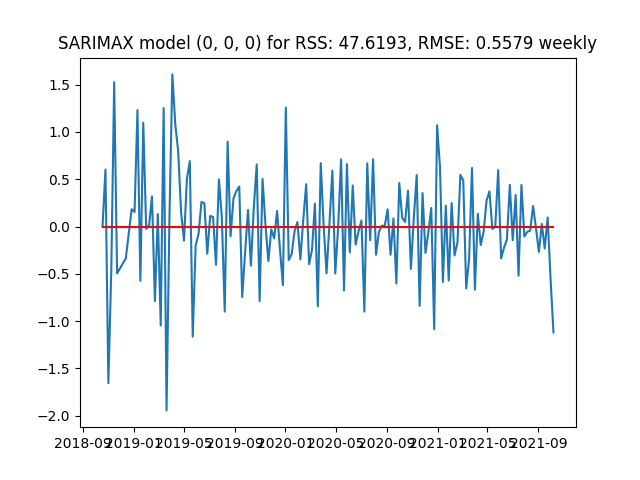

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
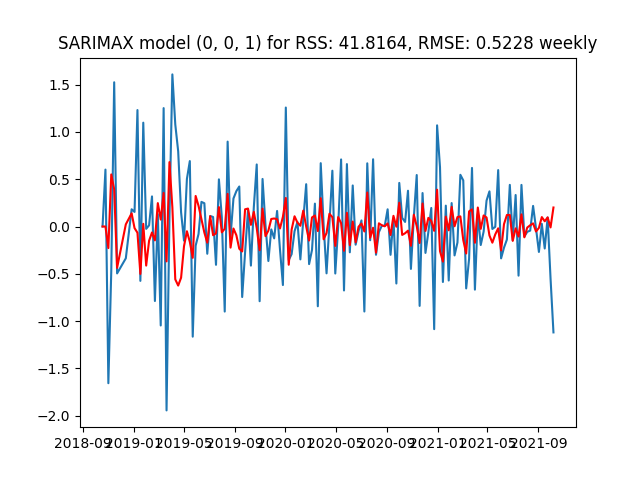

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
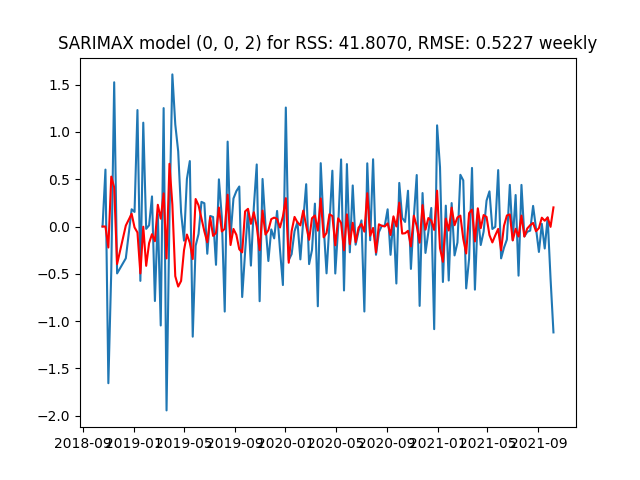

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
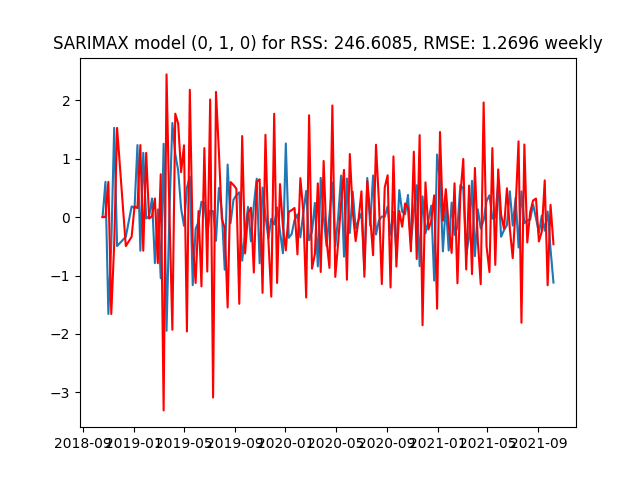

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
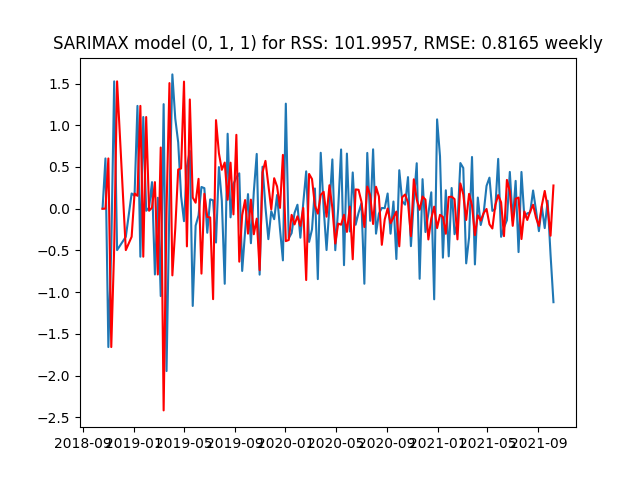

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
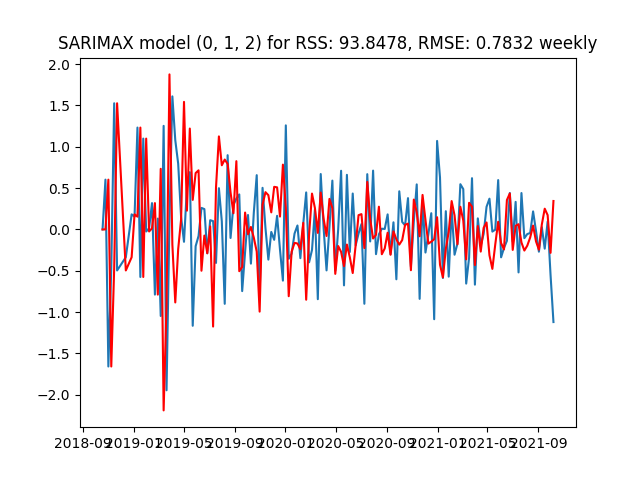

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
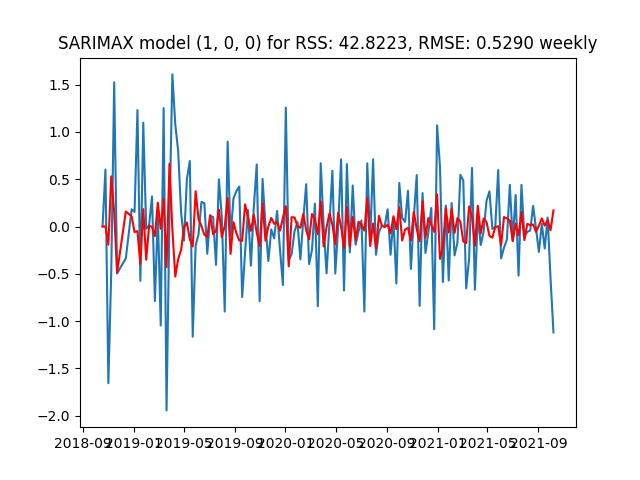

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
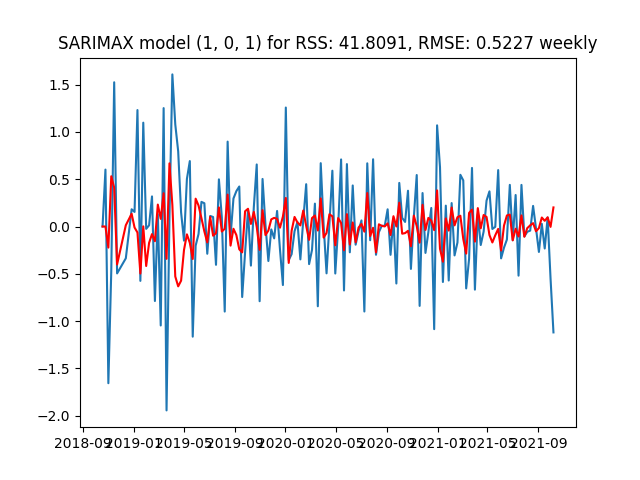

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
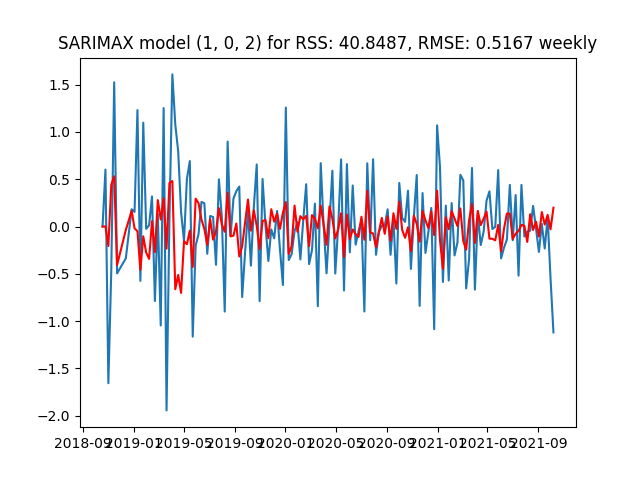

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
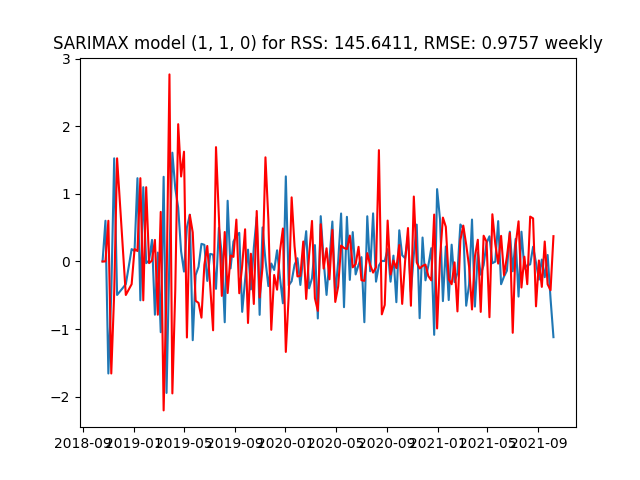

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
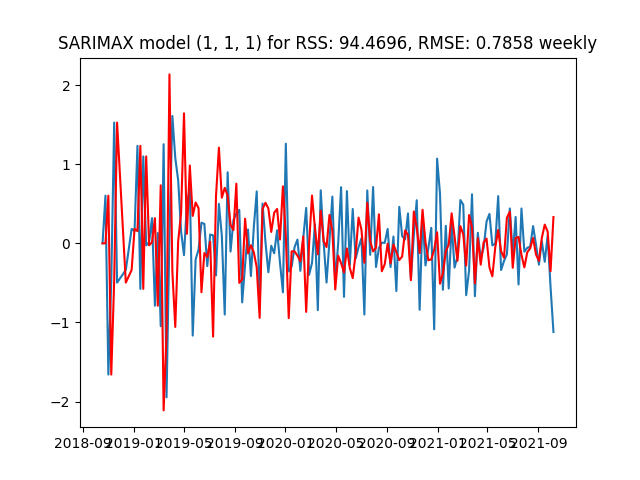

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
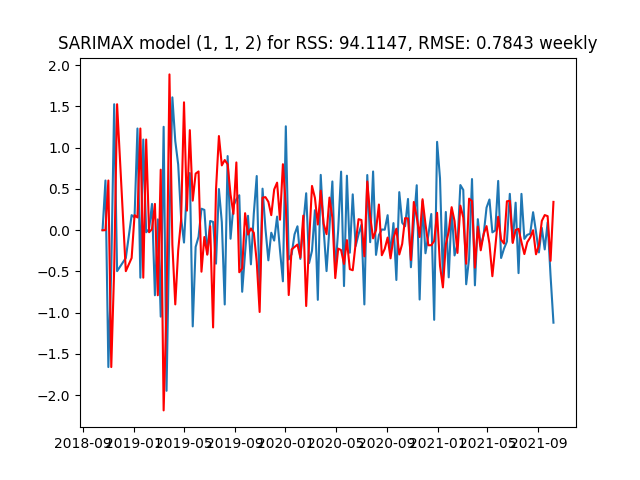

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
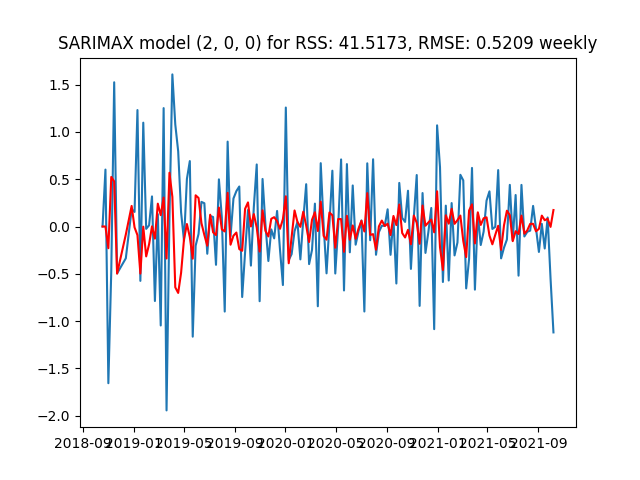

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
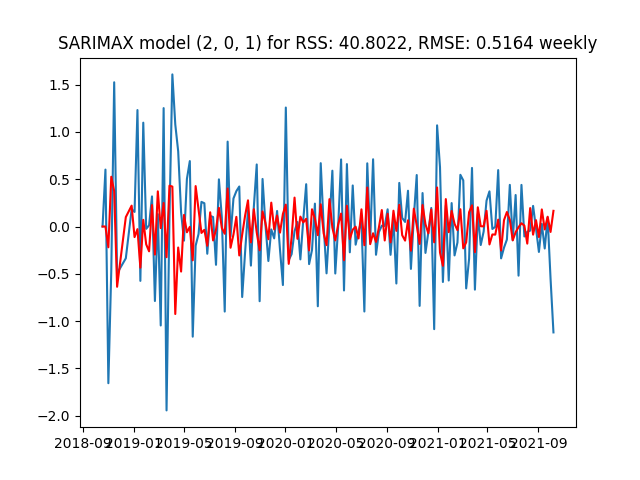

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
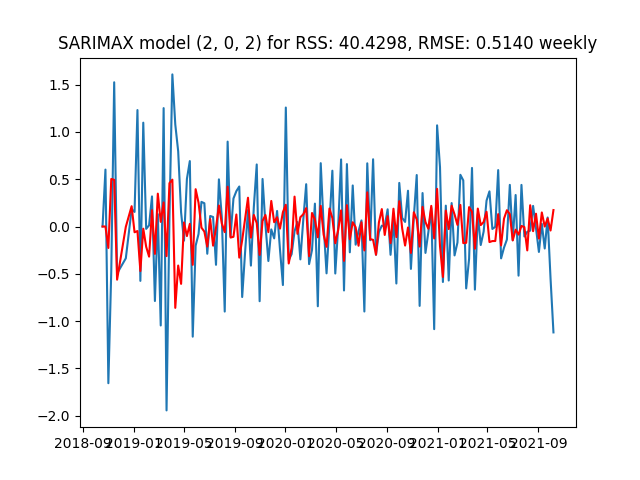

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
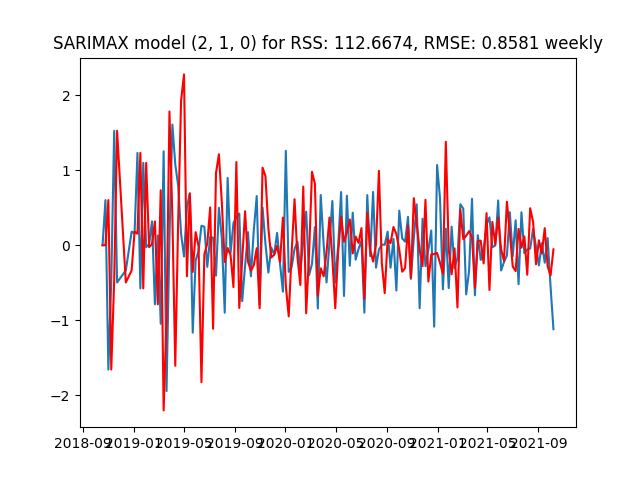

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
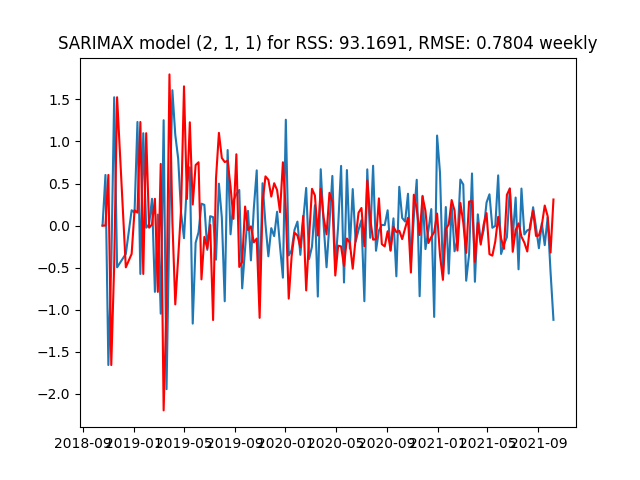

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
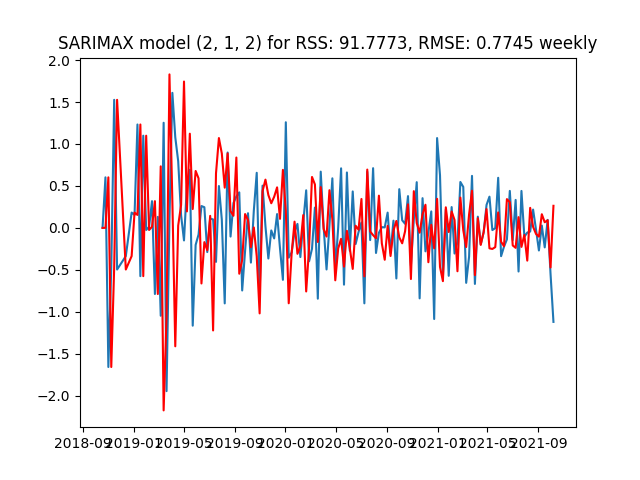

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
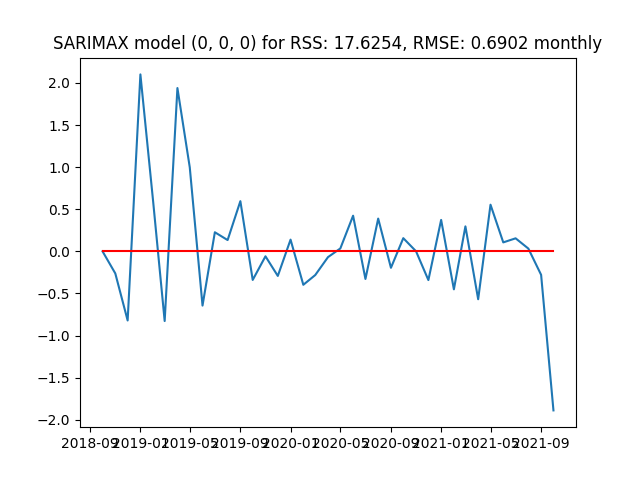

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
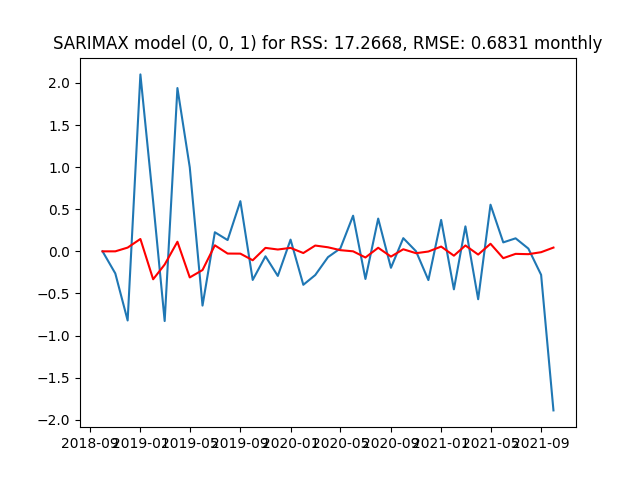

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
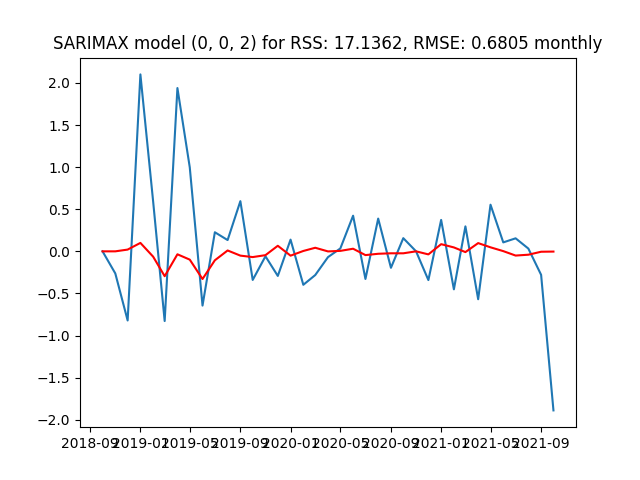

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
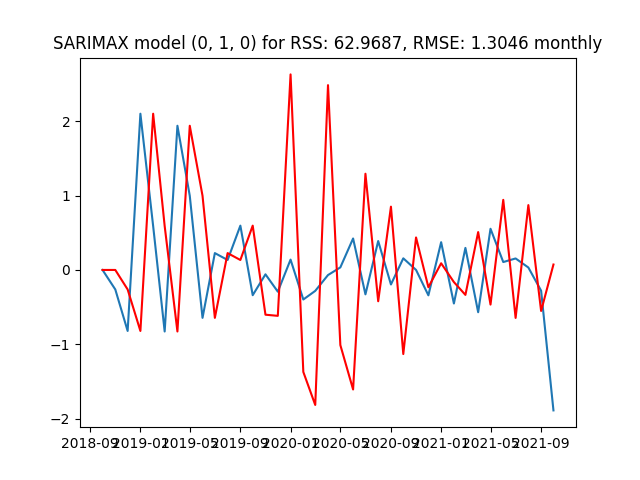

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
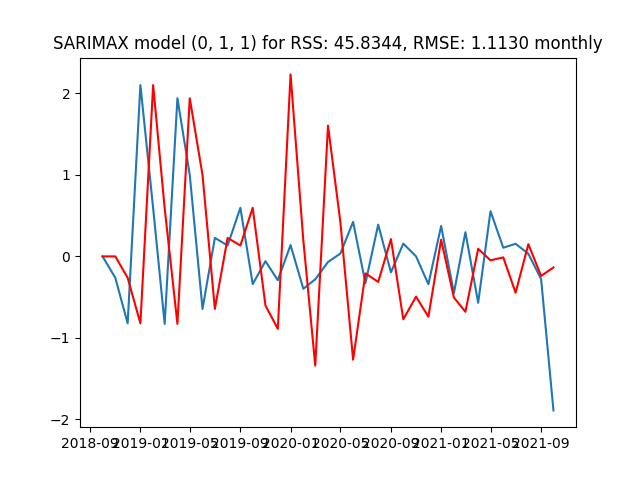

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
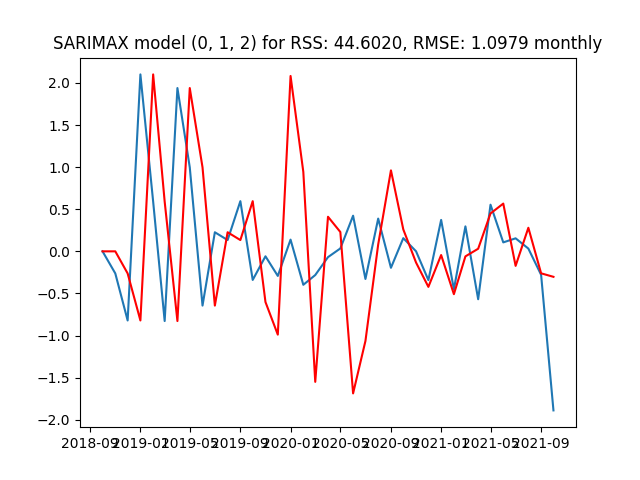

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
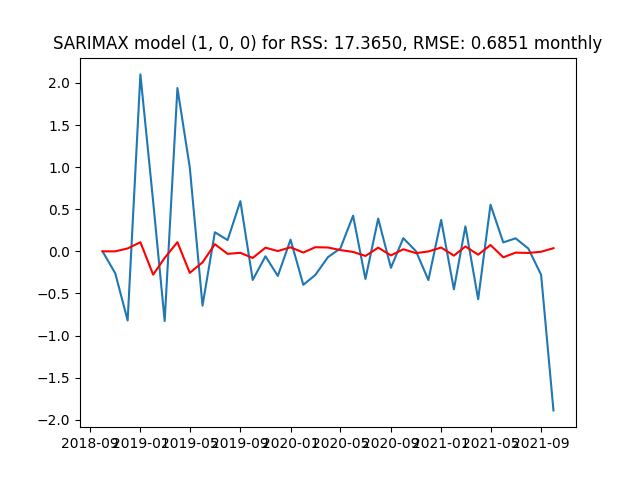

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
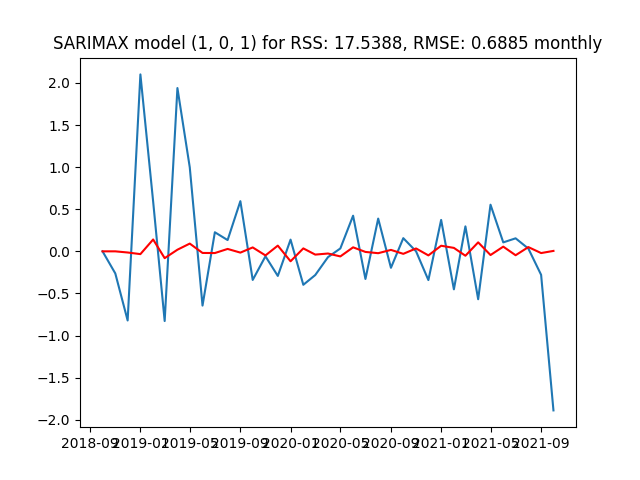

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
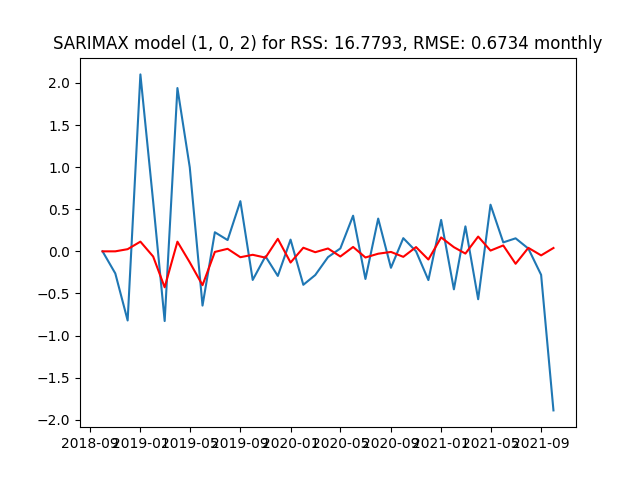

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
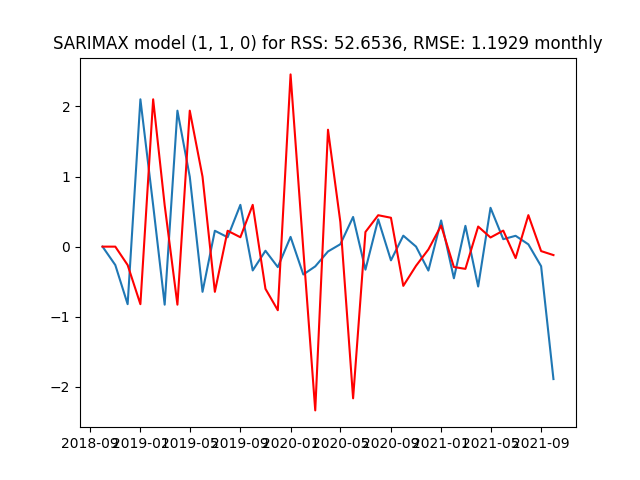

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
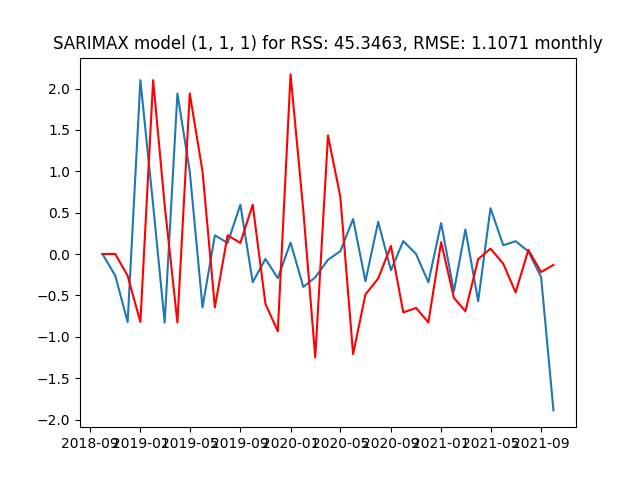

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
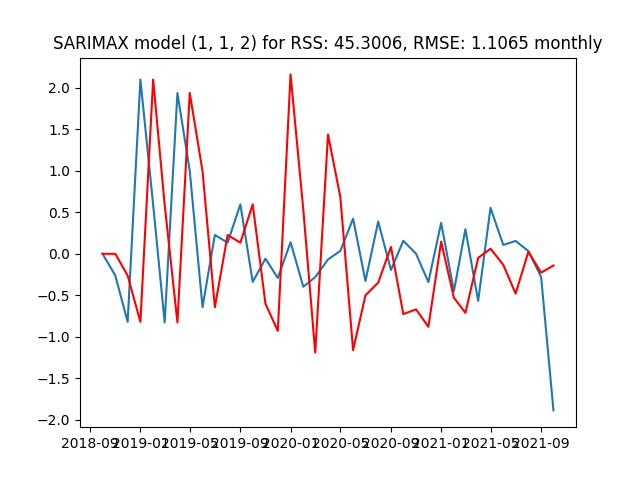

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
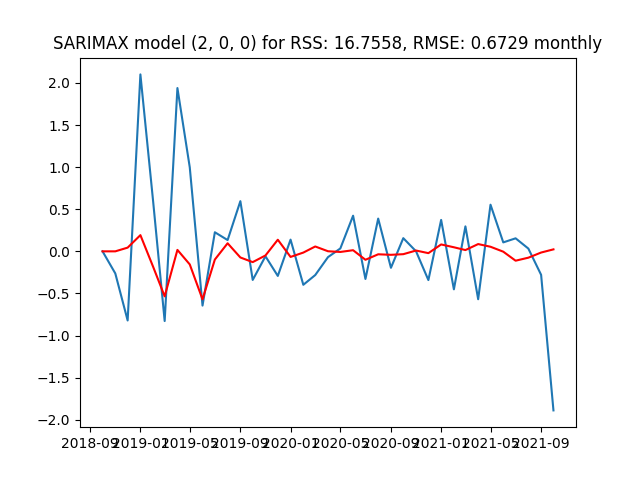

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
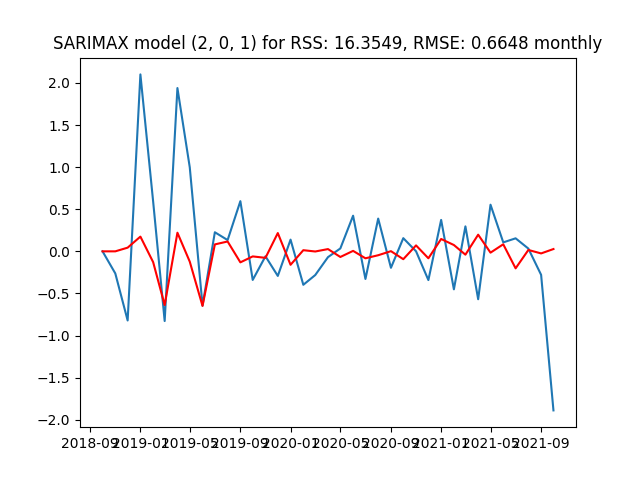

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
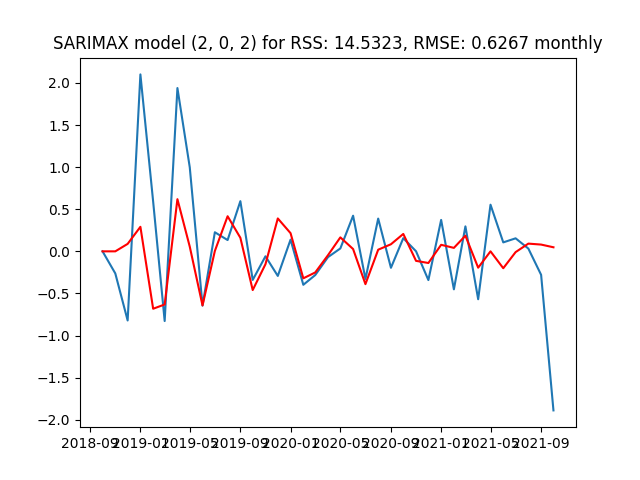

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
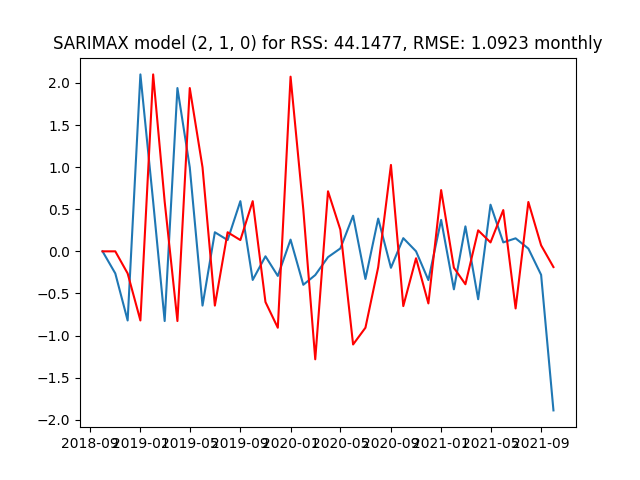

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
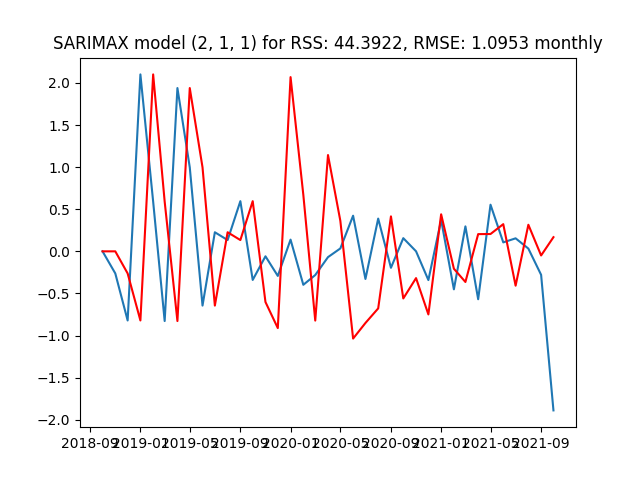

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
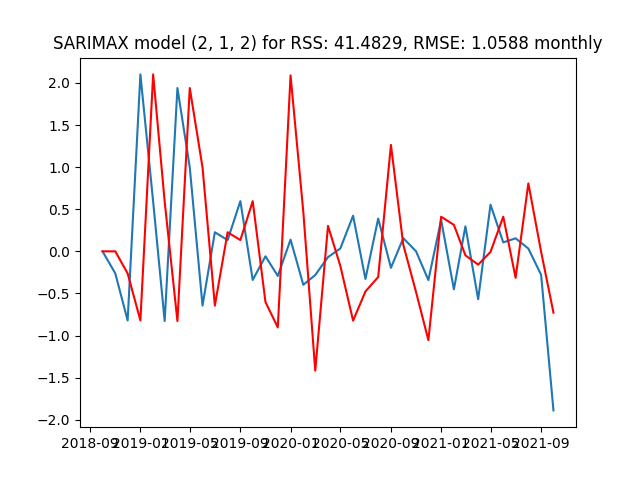

In [109]:
sarimax_dict = {}
model_list = []

for freq in zip(freq_dict.keys(), windows):
    for p in [0,1,2]:
        for d in [0,1]:
            for q in [0,1,2]:
                model_sa = run_sarimax_model(df=freq_dict[freq[0]].diff_shift.values,
                                             dates = freq_dict[freq[0]].Sale_Date.values, p=p, d=d, q=q,
                                             s=freq[1], freq=freq[0])
                if model_list == []:
                    model_list.append(model_sa)
                else:
                    if model_list[0][1] > model_sa[1]:
                        model_list[0] = model_sa
    sarimax_dict[freq[0]] = model_list[0]
    model_list = []
            

## **Prediction**

In [110]:
df = freq_dict['monthly'].to_pandas_df()
df.set_index('Sale_Date', inplace=True)
model = sarimax_dict['monthly'][0]
pred = pd.Series(model.fittedvalues, copy=True)

In [116]:
def transform(predictions, log):
    pred_cumsum = predictions.cumsum()
    pred_log = log
    pred_log = pred_log.add(pred_cumsum, fill_value=0)
    pred = np.exp(pred_log)
    return pred

In [128]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_df=pd.concat([df,future_datest_df])


In [131]:
future_df['forecast'] = transform(model.predict(start = 25, end = 60, dynamic= True), future_df.log)


In [37]:
fut = arima_dict['monthly'][0].predict(start=, end='2023-01')

In [38]:
fut[:len(freq_dict['monthly']['roll_mean'].values)] += freq_dict['monthly']['roll_mean'].values

In [39]:
fut['2021-11':] = fut[:'2021-11'].mean() + fut['2021-11':]

In [40]:
pred = np.exp(fut)

In [41]:
date = pd.date_range(start='2018-10', end='2022-11', freq='M')

In [72]:
def pred_plots(pred_x, pred_y, x, y, pred_label):
    fig = plt.figure()
    plt.plot(x, y, color='r', label=pred_label)
    plt.plot(x, y, color='g', label='Main Time Series')
    plt.legend(loc='best')
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
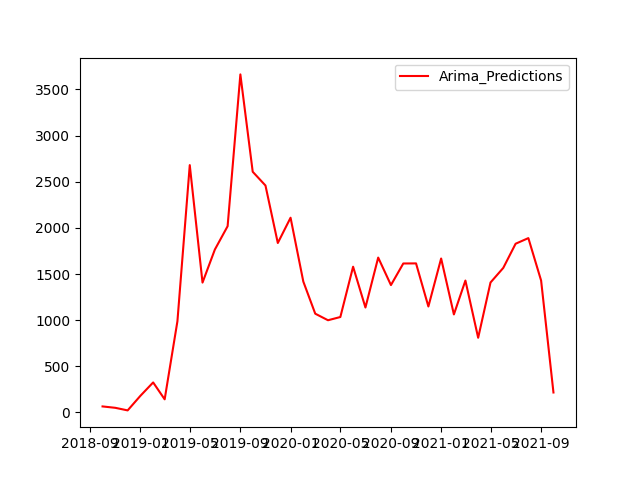

In [73]:
pred_plots(freq_dict['monthly']['Sale_Date'].values, freq_dict['monthly']['arima'].values,
           freq_dict['monthly']['Sale_Date'].values, freq_dict['monthly']['Quantity_In_Units'].values, "Arima_Predictions")

### **LSTM**